# FYP Assignment 3 - Data Preprocessing

Exploratory data analysis, visualization, and preprocessing of Zheng's energy consumption dataset.

# Exploratory Data Analysis

## Reading Data

In [68]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
# Reading the entire dataset into a pandas dataframe - tractable because 167 MB
data = pd.read_csv('./data.csv')

## Data Overview

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016/9/9
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


### Interpretation
- **42,372 rows** in the dataset, which means there are 42,372 training examples.
- **1,036 columns** in the dataset(!)
    - 1 is `CONS_NO`: the unique identifier for consumers in the dataset. This is most likely an `object`.
    - Another column is an `int64` - most likely the `FLAG`.
    - Remaining **1,034 columns are all kWhs, and are `float64`s**, so won't have to be cast later on.
- ~340M MB of memory used. Even on my PM laptop, this isn't too much.
    - This means I can play around with the data on a mid-tier laptop without waiting too much.

## Statistical Summary - Numerical Columns

Will examine the `mean`, `std`, `min`, `max`, and `count` for all columns except `CONS_NO`. This will also give me a good first look at the dataset.

In [4]:
# Save the description into a new dataframe to index counts for visualizing missing values
description_df = data.describe()

In [5]:
# Echo the dataframe
description_df

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


### Interpretation
- There are far too many columns in the dataset to identify missing, null, or erroneous values by inspection.
- There is a problem with the dates - they are not in the right order. 10th January, 2014 follows 1st January, 2014. Is this because the columns are being treated as strings?
- There are indeed 42,372 consumers, as shown in the `count` for the `FLAG`
- Missing values aplenty in the first few columns. 
- `FLAG` is the target variable: what we will be trying to predict.
    - Max and min values for the `FLAG` column are 0 and 1, which confirms that there is no erroneous value (negative flag, or third category of flag) in the target column.
    - All other columns (dates) are features: what we will be using to make classifications.
    - `mean` of `FLAG` is very close to 0, which suggests this is a right skewed binary distribution in which more consumers have `FLAG` of `0` as opposed to `1`.
    - **TODO**: Ask Dr. AB how to intepret standard deviation of `FLAG`.
    - No missing values in the `FLAG` column since `count` is same as number of rows in dataset. 

## Checking for Negative kWhs
Negative value for kWhs is erroneous data. Need to identify if such a value exists. Can't do this by inspection of `head`. Have to do it programmatically.

In [6]:
# Extract kWh values into a numpy array to check for negative values
kWh_vals = data.iloc[:, 2:].values

# Check that the numpy array has one row per consumer, one column per date
assert kWh_vals.shape == (len(data), len(data.columns[2:]))

In [7]:
# Is there any negative value in the kWhs?
np.any(data.iloc[:, 2:] < 0) == True

False

### Interpretation
This confirms that while there may be `NaN`s in the kWhs, there are no negative kWhs i.e. erroneous values. This is one less thing to worry about when preprocessing the data later.

## Visualizing Missing Values
We've established that there are no **negative** kWh readings in the dataset, which means there are only two types of values left for the kWh: positive `float64` or `NaN` aka missing values.

Since there are more than 1,000 columns in the dataset, using `head` to visualize missing values in each column (actually on each day) is intractable. 

Instead, creating a new dataframe of non-null values in each column of the dataset and plotting it to show the trend in the number of missing values in the dataset.

**This plot will not show a chronological trend** because the columns have not been sorted yet.

In [8]:
# Extract counts for all dates - this will then be plotted to visualize missing values
value_counts = description_df.loc['count'].drop('FLAG')

In [9]:
"""Create an array of ones scaled by the max number of value counts - this is the maximum
number of kWh values we could have at any given date. Making a list helps me plot this 
as a straight line on a graph as a threshold"""
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)

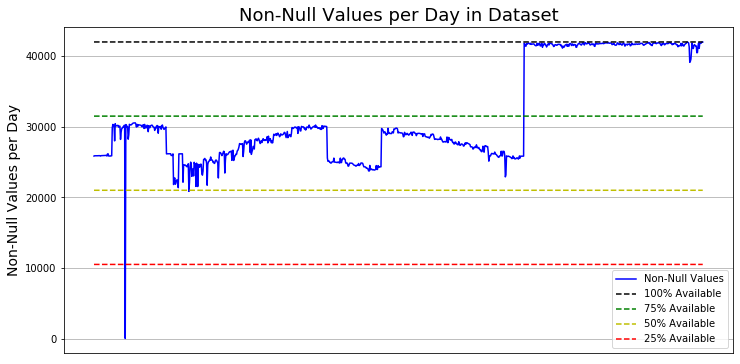

In [10]:
# Create plot of non-null values
plt.figure(figsize=(12, 6))
plt.plot(value_counts, 'b-', label='Non-Null Values')
plt.plot(max_threshold, 'k--', label='100% Available')
plt.plot(0.75 * max_threshold, 'g--', label='75% Available')
plt.plot(0.50 * max_threshold, 'y--', label='50% Available')
plt.plot(0.25 * max_threshold, 'r--', label='25% Available')
plt.xticks([]) # Do not want indices or dates for now
plt.ylabel('Non-Null Values per Day', fontsize=14)
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
plt.grid(); plt.legend()

### Interpretation
There is clearly **one day when the number of non-null values drop to ~0**. This day should be dropped from the data unless we can figure out how to fill in these missing values using data from previous and next days/weeks.

On most days, the number of non-null values is between 50% and 75% of the total number of consumers in the dataset. Near complete set of readings is only available towards the end of the dataset i.e in 2016.

There is also **no day where all 42,372 consumers reported a non-null reading**.

In [11]:
# Minimum number of non-null kW readings recorded on a day
min_readings = np.min(value_counts)
max_readings = np.max(value_counts) 
print(f"Min Readings: {min_readings}\nMax Readings: {max_readings}")

# What is the index of the column where minimum non-null value count occurs?
idx_min = value_counts.idxmin()

Min Readings: 15.0
Max Readings: 42044.0


In [12]:
# What is the date of the day with the 
idx_min

'2014/10/3'

In [13]:
# Display statistics for this day
data[[idx_min]].describe()

,2014/10/3
count,15.000000
mean,484.908667
std,772.293554
min,15.300000
25%,50.300000
50%,144.000000
75%,334.500000
max,2463.000000


### Interpretation
The number of non-null values in the dataset dropped to 15 on 3rd October, 2014. 

**TODO**: Ask Dr. AB whether we should drop this column from the sequence entirely. 

## Class Distribution

In [14]:
# Count non-null values in each column based on FLAG column value
grouped_by_flag = data.groupby('FLAG').count()
grouped_by_flag

,CONS_NO,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
FLAG,,,,,,,,,,,,,,,,,,,,,
0,38757,23742,23773,23773,23773,23772,23774,23778,23781,23782,...,37121,38025,38413,37674,38403,38374,38341,38459,38544,38526
1,3615,2128,2139,2138,2139,2140,2138,2137,2143,2143,...,3423,3457,3502,3477,3503,3499,3509,3508,3500,3501


In [15]:
# Extract the number of consumers
grouped_by_flag[['CONS_NO']]

,CONS_NO
FLAG,
0,38757
1,3615


In [16]:
# What does this mean in terms of percentage of total consumers?
print("%age distribution of classes\nb")
print(grouped_by_flag[['CONS_NO']]/len(data[['CONS_NO']]))

%age distribution of classes
b
       CONS_NO
FLAG          
0     0.914684
1     0.085316


Text(0.5, 1.0, 'Class Distribution')

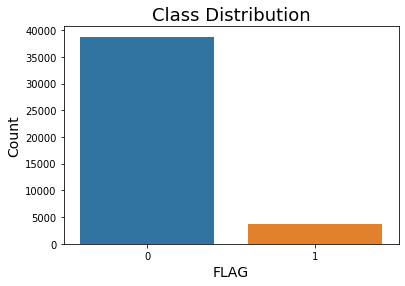

In [17]:
# Countplot will distribute values according to class
sns.countplot(x='FLAG', data=data)
plt.xlabel('FLAG', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Class Distribution', fontsize=18)

### Interpretation
This is an **unbalanced classification problem** - there is a **91.5-8.5% split** between negative and positive (target) class in the dataset. This corroborates earlier finding of right skewed distribution and low mean.

## Visualizing Missing Values per Category
Do regular consumers have more or fewer missing values than thieves? Are thieves bypassing their electricity meters more than regular consumers?

In [18]:
# Echoing because I'm lazy
grouped_by_flag.head()

,CONS_NO,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
FLAG,,,,,,,,,,,,,,,,,,,,,
0,38757,23742,23773,23773,23773,23772,23774,23778,23781,23782,...,37121,38025,38413,37674,38403,38374,38341,38459,38544,38526
1,3615,2128,2139,2138,2139,2140,2138,2137,2143,2143,...,3423,3457,3502,3477,3503,3499,3509,3508,3500,3501


In [19]:
# Get regular consumer's non-null values. 1st column onwards selects counts on each day
reg_non_null_counts = grouped_by_flag.iloc[0, 1:] 
thieves_non_null_counts = grouped_by_flag.iloc[1, 1:]

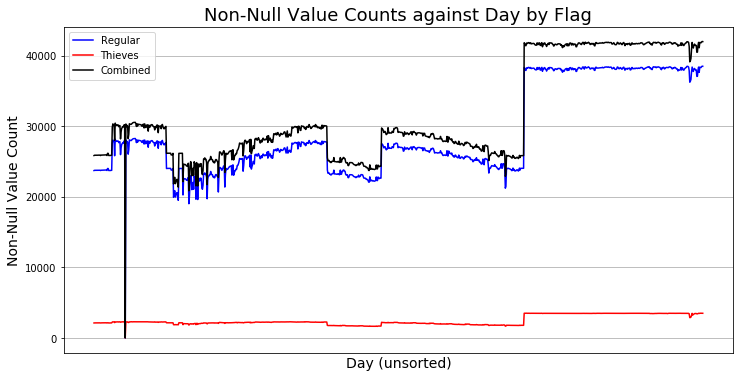

In [20]:
# Plot the number of non-null values per day for each class along with total number of non-null values per day
plt.figure(figsize=(12, 6))
plt.plot(reg_non_null_counts, 'b-', label='Regular')
plt.plot(thieves_non_null_counts, 'r-', label='Thieves');
plt.plot(value_counts, 'k-', label='Combined')
plt.title('Non-Null Value Counts against Day by Flag', fontsize=18)
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
plt.ylabel('Non-Null Value Count', fontsize=14); plt.grid(True); plt.legend()

### Interpretation
This plot shows that there is a lot more variation in the number of missing values for regular consumers than in those of thieves. The number of non-null values in thieves is more or less a flat line with an occasional jump here and there.

However, this may just be because the proportion of thief values in the dataset is very small, so on the scale of this graph, it gives the false impression that there isn't much variation. There could be a substantial number of missing thief values as a percentage of the total thief values. Needs further investigation.

This would also explain why the overall trend follows the pattern of the number of non-null regular consumers per day so closely. The number of regular consumers' non-null values is dominating the overall number of missing values. 

In [21]:
# Total number of consumers - found using number of unique consumer numbers
total_consumers = data[['CONS_NO']].nunique()
print("Total Consumers: ", total_consumers)

# Total number of regular consumers and thieves - found by grouping by flag
total_reg_consumers = grouped_by_flag[['CONS_NO']].loc[0]
total_thieves = grouped_by_flag[['CONS_NO']].loc[1]

print("Regular Consumers: ", total_reg_consumers)
print("Thieves: ", total_thieves)

Total Consumers:  CONS_NO    42372
dtype: int64
Regular Consumers:  CONS_NO    38757
Name: 0, dtype: int64
Thieves:  CONS_NO    3615
Name: 1, dtype: int64


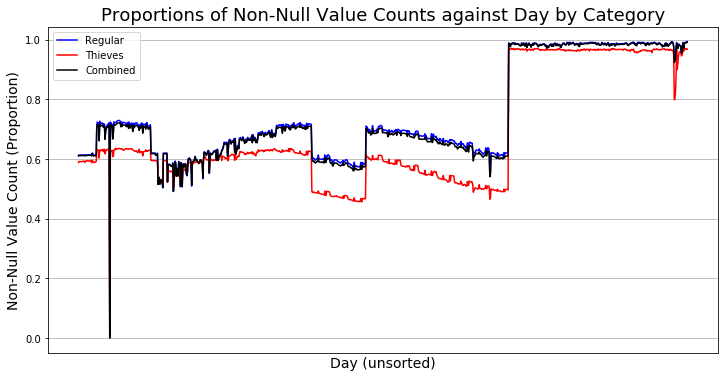

In [22]:
# Will use these constants to plot non-null values as proportion of their respective category
plt.figure(figsize=(12, 6))
plt.plot(reg_non_null_counts / float(total_reg_consumers), 'b-', label='Regular')
plt.plot(thieves_non_null_counts / float(total_thieves), 'r-', label='Thieves');
plt.plot(value_counts / float(total_consumers), 'k-', label='Combined')
plt.title('Proportions of Non-Null Value Counts against Day by Category', fontsize=18)
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
plt.ylabel('Non-Null Value Count (Proportion)', fontsize=14); plt.grid(True); plt.legend()

### Interpretation

This graph gives a much better indication of the number of missing values per day for the entire dataset (shown in the black line) as well as for individual categories (thieves and regular consumers shown in red and blue respectively).

It confirms my suspicion that the apparent lack of variation in number of non-null thief values was only due to the scale of the raw thief counts being orders of magnitude smaller than those of regular consumers and the entire dataset. Once the number of non-null kWh readings for thieves per day are scaled by the maximum number of values that could have been measured, the trend is very similar to the entire dataset and to the regular consumers.

**Ideas to Consider**
- **Missing Values As Features**: There is a significant difference (~-0.1 units) between the proportion of non-null values for thieves and regular consumers. Could this mean that the absence of kWh readings can be a possible feature for distinguishing the two?
- **Why**: why is there a difference between the proportion of non-null values for thieves and regular consumers? Could this be due to thieves bypassing their meters? Is this relevant?

## Rearranging Columns Chronologically (Test)

The most glaring issue in the dataset right now, other than the large number of `NaN`s is the fact that the dataset's columns are not sorted chronologically. This isn't a problem with `pandas` or the way it reads values from a CSV: the same sequence of columns is present in the original CSV when examined with Excel.

In [23]:
# What is the data type of the columns?
cols = data.columns.tolist()

# Output the values starting from the 2nd index 
print(cols[2:10])

# What is the type of each of these dates? Is it a string or a datetime?
print(type(cols[2]))

['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16']
<class 'str'>


### Interpretation
The dates are stored as **strings** and not as `datetime` objects, which would explain why they appear to be out of order: they are sorted lexicographically rather than chronologically.

The solution is to convert each column header from `string` to `datetime`, and then sort the dataset according to `datetime` values in ascending order. This will get rid of the lack of sequence.

In [29]:
# Making a copy of the dataset to test modification of columns
new_df = data.iloc[:,:]

In [30]:
# Should be the same as the original dataset
new_df.describe()

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


In [31]:
# Extract the date columns only - not `FLAG` or `CONS_NO`
columns = new_df.columns[2:]

In [32]:
# Convert to datetime in specified format
new_cols = pd.to_datetime(columns)

In [33]:
# Attempt to sort after casting to datetime
new_cols.sort_values()

DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31'],
              dtype='datetime64[ns]', length=1034, freq=None)

In [34]:
# Checking indices of original columns list to identify where dates begin
print(new_df.columns[:2])
print(new_df.columns[2:])

Index(['CONS_NO', 'FLAG'], dtype='object')
Index(['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13',
       '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18',
       ...
       '2016/9/28', '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4',
       '2016/9/5', '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9'],
      dtype='object', length=1034)


Extract first two columns (`CONS_NO` and `FLAG`) because they don't need to be cast to `datetime`. Then extract the actual date strings (column indices 2 onwards) and cast them to `datetime` and extract **only** the date using the `date` attribute - without it, all column names have an unnecessary `00:00:00` at the end. 

Must concatenate both sets of columns as lists and then assign the result to the new dataframe's columns.

In [35]:
# Concatenate original `CONS_NO` and `FLAG` with **UNSORTED** datetime column names
new_df.columns = new_df.columns[:2].tolist() + pd.to_datetime(new_df.columns[2:]).date.tolist()

In [36]:
# Did it work?
new_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


It worked. Now to sort the columns in ascending order.

In [37]:
# Extract list of column names
dt_cols = new_df.columns[2:]

# Sort them in ascending order
sorted_dt_cols = dt_cols.sort_values()

# Did it work?
print(sorted_dt_cols[:25]) 

Index([2014-01-01, 2014-01-02, 2014-01-03, 2014-01-04, 2014-01-05, 2014-01-06,
       2014-01-07, 2014-01-08, 2014-01-09, 2014-01-10, 2014-01-11, 2014-01-12,
       2014-01-13, 2014-01-14, 2014-01-15, 2014-01-16, 2014-01-17, 2014-01-18,
       2014-01-19, 2014-01-20, 2014-01-21, 2014-01-22, 2014-01-23, 2014-01-24,
       2014-01-25],
      dtype='object')


In [38]:
# Extract the kW into a separate df
kw_df = new_df.iloc[:, 2:]

In [39]:
kw_df.head()

,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [40]:
# Extract the consumer number and flags
cons_flags_df = new_df.iloc[:, :2]

# Extract the kWhs separately
kWhs_df = new_df.iloc[:, 2:]

# Sort the kWhs dataframe according to their columns
kWhs_df.sort_index(axis=1, inplace=True, ascending=True)

# Did it work?
kWhs_df.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [41]:
# For merging the two dataframes together by INNER JOIN, use CONS_NO as key
kWhs_df.insert(0, 'CONS_NO', new_df[['CONS_NO']])

In [42]:
kWhs_df.head()

,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [43]:
# Join the dataframes using CONS_NO as key
sorted_df = pd.merge(left=cons_flags_df, right=kWhs_df, how='left', 
                    on='CONS_NO', left_index=True, right_index=False)

In [44]:
# Did it work?
sorted_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [45]:
# Compare to original data
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,...,2016-09-28,2016-09-29,2016-09-03,2016-09-30,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [47]:
# Save to a new CSV file that can be loaded in future sessions
# `index` = False means data won't have an additional col of [0, 1, 2, ..., 42371]
sorted_df.to_csv('./sorted_data.csv', index=False)

### Recap of Sorting Workflow
1. Separate into 2 dataframes - the first being `CONS_NO` and `FLAG`, and the second being `kWhs` 
    - Including `CONS_NO` in both because it helps me join them using `CONS_NO` as a key.
    - Do not include the `CONS_NO` with the `kWhs` at first. Will be done later.
2. Extract column names from the kWhs dataframe and cast them to `datetime` objects.
    - Drop the time, only the date is necessary.
    - Reassign the column names. Don't save them into a separate variable.
3. Use the `sort_index` method on the `kWh` dataframe to reorganize columns in chronological order.
4. Insert the `CONS_NO` column in the sorted/rearranged `kWh` dataframe.
    - Can insert it at any location, but I prefer to use the first column because it is a key.
    - This will be used as a key for merging the constituent dataframes together.
5. Use `merge` to perform an inner join on the two dataframes using the `CONS_NO` column as a key. This eliminates any risk of the rows being combined in the wrong order, or being rearranged due to mismatches.
    - Interpreter was displaying a warning which said something about sorting rows because of a mismatch.
    - Inner join with `merge` avoids this issue entirely.

## Missing Values in Sorted Data

Now that data has been sorted, we can try and figure out a trend in the number of missing values per day. 

In [2]:
data = pd.read_csv('./sorted_data.csv')

In [72]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [82]:
# Extracting number of non-null values per day
value_counts = data.describe().loc['count'].drop('FLAG')

# Defining line that will be scaled to create thresholds in non-null plot
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)

In [87]:
# Convert to dataframe so I don't have to deal with date formatting
value_counts_df = pd.DataFrame(value_counts)

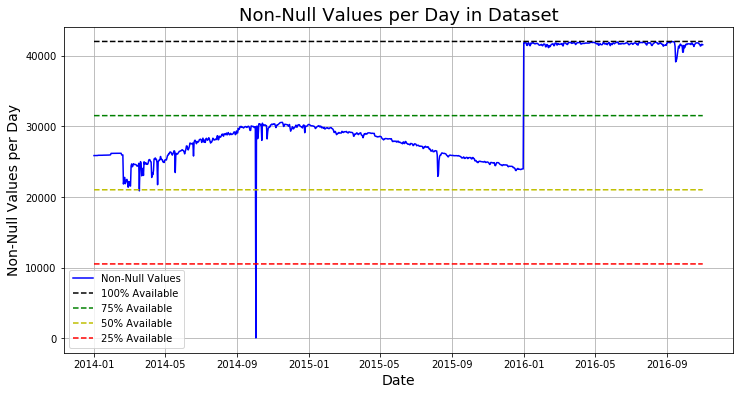

In [108]:
# Create plot of non-null values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values, 'b-', label='Non-Null Values')
plt.plot(value_counts_df.index.to_pydatetime(), 
    max_threshold, 'k--', label='100% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.75 * max_threshold, 'g--', label='75% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.50 * max_threshold, 'y--', label='50% Available')
plt.plot(value_counts_df.index.to_pydatetime(), 
         0.25 * max_threshold, 'r--', label='25% Available')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Non-Null Values per Day', fontsize=14)
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
plt.grid(); plt.legend()

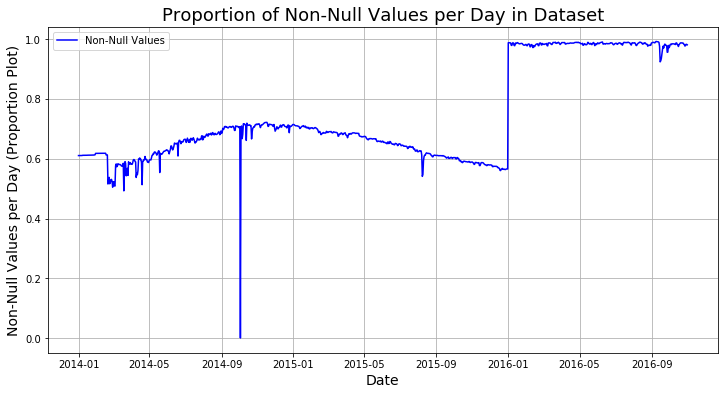

In [107]:
# Create plot of non-null values as proportion of all available values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values / len(data[['CONS_NO']]), 
         'b-', label='Non-Null Values')
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
plt.title('Proportion of Non-Null Values per Day in Dataset', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.grid(); plt.legend()

### Interpretation
Now that the data has been sorted chronologically, we can see there is a trend in the number of missing values with time. 
- Number of non-missing values increases to 30k by late 2014, drops to 15 in 10/2014, and then rises back again.
- It then declines steadily to the beginning of 2016.
- From the beginning of 2016, the number of non-null values is virutally the same as the max number of consumers (~99%).
- For the majority of the dates, the number of non-null values is between 50 and 75%.

## Missing Values per Consumer
Now that we've visualized the trend in the number of missing values per day, we're going to look at the number of missing values per consumer. That is, how many missing values did each consumer report across the 1,034 days that data was recorded?

In [12]:
consumer_non_null_vals = data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:])

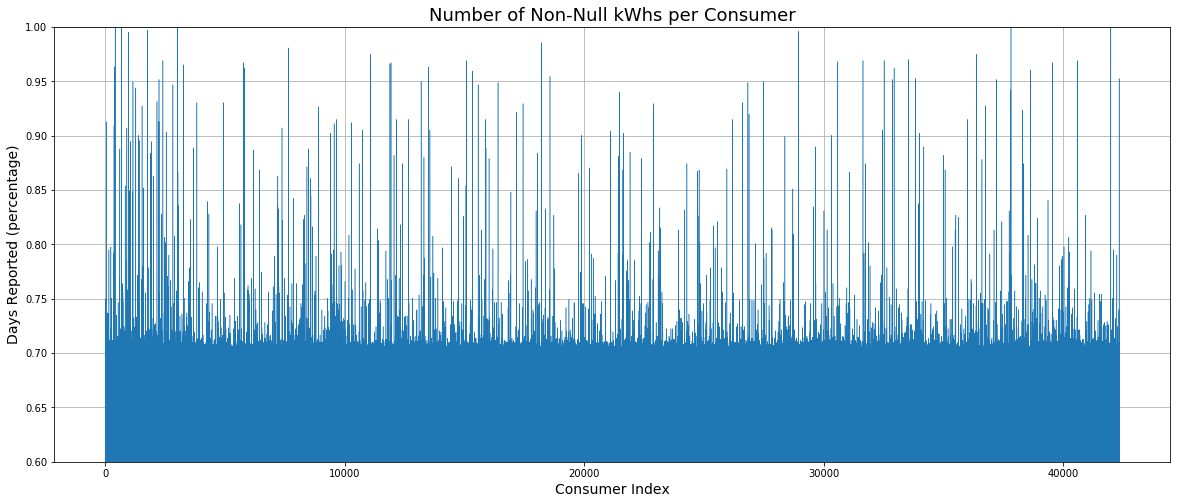

In [13]:
plt.figure(figsize=(20, 8))
plt.plot(consumer_non_null_vals, linewidth=0.5)
plt.xlabel('Consumer Index', fontsize=14)
plt.ylim([0.6, 1])
plt.ylabel('Days Reported (percentage)', fontsize=14)
plt.title('Number of Non-Null kWhs per Consumer', fontsize=18)
plt.grid()

In [14]:
print("Minimum number of values: ", np.min(consumer_non_null_vals))
print("Maximum number of values: ", np.max(consumer_non_null_vals))

Minimum number of values:  0.0009671179883945841
Maximum number of values:  1.0


In [15]:
0.000967 * 1035

1.000845

### Interpretation
- Almost all consumers have reported a non-null value for at least 70% of the days.

- Very few consumers have reported near to 42,372 values.
- One consumer has reported NaNs on less than 0.0009% of days i.e. exactly 1 of 1,035 days.
- This plot doesn't tell us very much. Need to aggregate consumer values.

## Aggregating Consumers by Missing Values

In [2]:
data = pd.read_csv('./sorted_data.csv')

In [3]:
consumer_non_nulls = pd.DataFrame(data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:]))

In [4]:
ranges = np.arange(0, 1.1, 0.1)

In [5]:
consumer_grouped_non_nulls = consumer_non_nulls.groupby(pd.cut(consumer_non_nulls.iloc[:, 0], ranges)).count()

In [6]:
consumer_grouped_non_nulls.columns =  ['Count']

In [7]:
consumer_grouped_non_nulls

,Count
0,
"(0.0, 0.1]",20997
"(0.1, 0.2]",4614
"(0.2, 0.3]",2383
"(0.3, 0.4]",1706
"(0.4, 0.5]",1488
"(0.5, 0.6]",552
"(0.6, 0.7]",1114
"(0.7, 0.8]",9324
"(0.8, 0.9]",114


In [14]:
num_consumers = len(data['CONS_NO'])

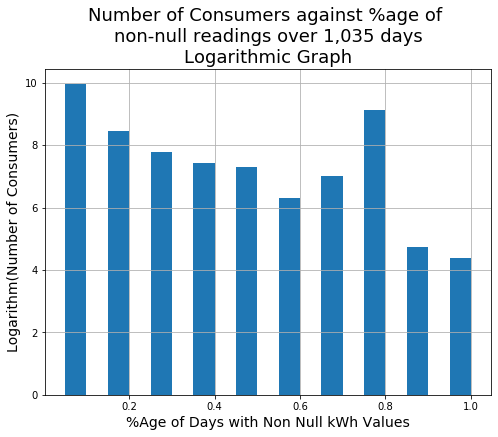

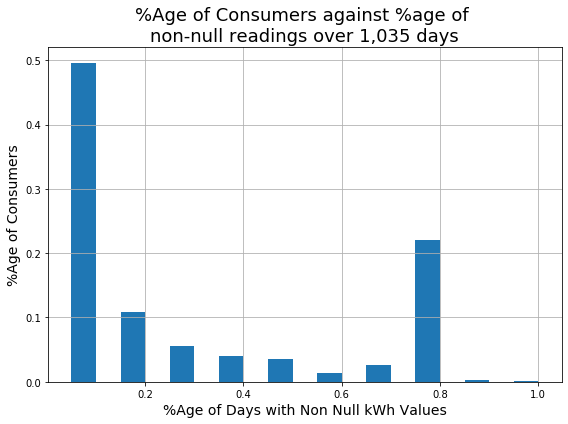

In [19]:
# First plot is logarithmic values
plt.figure(figsize=(8, 6))
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
       height=np.log(consumer_grouped_non_nulls['Count']),
       width=-0.05, linewidth=0.1, align='edge')
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
plt.ylabel('Logarithm(Number of Consumers)', fontsize=14)
plt.title('Number of Consumers against %age of \nnon-null readings over 1,035 days\nLogarithmic Graph', fontsize=18)
plt.grid(True)
plt.tight_layout()

# Second plot is raw count as a percentage of all consumers
plt.figure(figsize=(8, 6))
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
        height=consumer_grouped_non_nulls['Count'] / num_consumers, width=-0.05,
        linewidth=0.1, align='edge')
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
plt.ylabel('%Age of Consumers', fontsize=14)
plt.title('%Age of Consumers against %age of \nnon-null readings over 1,035 days', fontsize=18)
plt.grid(True)

plt.tight_layout()

### Interpretation
- ~50% of the consumers in the dataaset have reported non-null kWh readings for <= 10% of 1,035 days.
- The next largest common percentage is between 70% and 80%: this means 22% of consumers have reported non-null values on at least 80% of all days. 

## Replacing `NaN`s
 
In their paper, Zheng et. al (2017) have used the following approach for replacing missing values.
The kWhs consumed on a day $i$ are denoted by $x_i$. If $x_i$ = `NaN`, then

### Case 1: Previous and Next kWhs both Defined
If $x_{i-1}, x_{i+1} \notin$ `NaN`, then $$x_i = \frac{x_{i+1} + x_{i-1}}{2}$$.
The current day's kWhs are the average of the kWhs consumed on the next and previous days.

### Case 2: Previous or Next kWhs Undefined
If $x_{i+1} \in$ `NaN` **OR** $x_{i-1} \in$ `NaN`, then $$x_i = 0$$.
The authors have assumed that if either of the next or previous days' kWhs are undefined, we will assume the current day's kWhs to be 0. 

**In all other cases, the authors make no change to the value of $x_i$**.

In [35]:
import time

In [36]:
# Reading data
t_0 = time.time()
data = pd.read_csv('./sorted_data.csv')
elapsed = time.time() - t_0
print(elapsed)

6.874460220336914


In [37]:
# Extract kWhs as numpy array
kWhs = data.iloc[:, 2:].values

In [38]:
# Confirm correct data extracted and 
rows, cols = kWhs.shape
print("Rows (number of consumers)\t: ", rows)
print("Columns (number of days)\t: ", cols)

Rows (number of consumers)	:  42372
Columns (number of days)	:  1034


In [39]:
t_0 = time.time()
for row in list(range(0, rows)):
    # Can't modify the first and last columns so no point checking for them
    for col in list(range(1, cols - 1)):
        # Only for the `NaN`s
        if (np.isnan(kWhs[row, col])):
            # If NaN today OR tomorrow, set to 0.0
            if (np.isnan(kWhs[row, col - 1]) or np.isnan(kWhs[row, col + 1])):
                kWhs[row, col] = 0.0

            # If defined today AND tomorrow, set to mean - isnfinite practically same as ~isnan
            elif (np.isfinite(kWhs[row, col - 1] and np.isfinite(kWhs[row, col + 1]))):
                kWhs[row, col] = np.mean([kWhs[row, col - 1], kWhs[row, col + 1]])

# How long did this take lol
t_f = time.time()
(t_f - t_0) / 60

2.6468756993611655

In [40]:
# Replace old data with new data
data.iloc[:, 2:] = kWhs

In [43]:
# Did it work?
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


### Visualizing Effect of Interpolation - Per Day Non-Nulls

In [45]:
# Extracting number of non-null values per day
value_counts = data.describe().loc['count'].drop('FLAG')

# Convert to dataframe so I don't have to deal with date formatting
value_counts_df = pd.DataFrame(value_counts)

In [50]:
value_counts_df.index = pd.DatetimeIndex(value_counts.index)

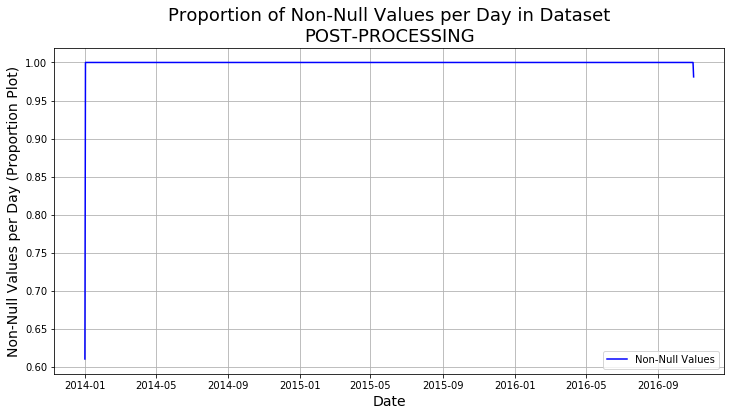

In [53]:
# Create plot of non-null values as proportion of all available values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values / len(data[['CONS_NO']]), 
         'b-', label='Non-Null Values')
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
plt.title('Proportion of Non-Null Values per Day in Dataset\nPOST-PROCESSING', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.grid(); plt.legend()

### Interpretation
- The interpolation seems to have worked. Now there are virtually no missing values on each day.
- The sharp drops at 2014-01-01 and 2016-12-31 are because these are the first and last dates in the dataset respectively, and as per Zheng et. al's rules, no interpolation has been defined for values on these days. Thus, these days do still contain missing values.
- **TODO**
    - How to deal with this? Drop these columns? Will 2 days make a difference when we have data for 1,034?
    - Is there a better way to deal with this that doesn't involve discarding these columns?

### Visualizing Effect of Interpolation - Per Consumer Non-Nulls

In [54]:
consumer_non_nulls = pd.DataFrame(data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:]))
ranges = np.arange(0, 1.1, 0.1)
consumer_grouped_non_nulls = consumer_non_nulls.groupby(pd.cut(consumer_non_nulls.iloc[:, 0], ranges)).count()
consumer_grouped_non_nulls.columns =  ['Count']
consumer_grouped_non_nulls

,Count
0,
"(0.0, 0.1]",17022
"(0.1, 0.2]",0
"(0.2, 0.3]",0
"(0.3, 0.4]",0
"(0.4, 0.5]",0
"(0.5, 0.6]",0
"(0.6, 0.7]",0
"(0.7, 0.8]",0
"(0.8, 0.9]",0


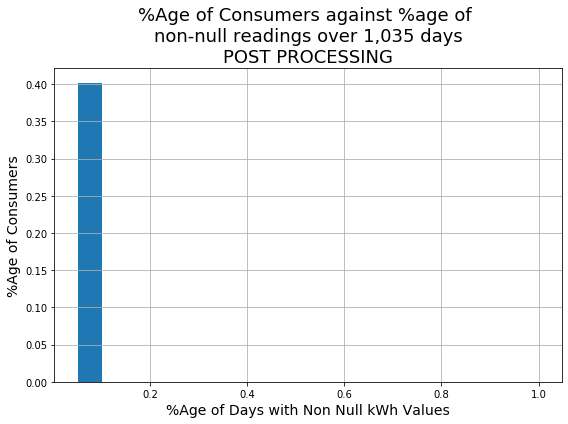

In [59]:
# Plotting Results
num_consumers = len(data['CONS_NO'])

# Plot is raw count as a percentage of all consumers
plt.figure(figsize=(8, 6))
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
        height=consumer_grouped_non_nulls['Count'] / num_consumers, width=-0.05,
        linewidth=0.1, align='edge')
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
plt.ylabel('%Age of Consumers', fontsize=14)
plt.title('%Age of Consumers against %age of \nnon-null readings over 1,035 days\nPOST PROCESSING', fontsize=18)
plt.grid(True)

plt.tight_layout()

### Interpretation
- Virtually no consumers have missing values on more than 10% of the 1,035 days. 
- Number of consumers with missing values  between 0 - 10% of the days has decreased from 20,997 to 17,022, which represents an ~20% decrease.

In [61]:
# Write interpolated data to file
data.to_csv('./data-interpolated.csv')

## TODOs
- Scale down outliers using three sigma rule.
- Feature scaling using `MinMax` scaler.
- Dealing with first and last day's data - no interpolation done according to Zheng's rules.
- Create dataset of weekly data.

## Outliers
Zheng defines outliers on a weekly basis: for every consumer, kWh values that are 2 standard deviations higher than the mean of the kWhs for **all consumers on that day** are considered as outliers. This is a variation of the so called **three-sigma rule of thumb** for identifying outliers.

### Zheng's Assumptions
Zheng assumes that no kWh value can be more than 2 standard deviations higher than its daily average for all consumer, and caps these outliers at the 2-sigma threshold. Zheng further assumes that only positive deviations from the mean should be considered when identifying outliers, because 'because the electricity consumption of each user is always greater than 0 after analyzing the electricity consumption data of 1,035 days'.

Concretely, the kWh consumption on the $i^{th}$ day $x_i$ is considered to be an outlier if 
$$x_i > avg(X) + 2\times std(X)$$ 
where $X$ is the vector of all kWh consumption values on that day.

In [208]:
data = pd.read_csv('./data-interpolated.csv')

In [15]:
data = data.drop('Unnamed: 0', axis=1)

## Number of Outliers per Day

In [16]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [17]:
# Extract first few rows and cols for testing
test = data.iloc[:, 2:]

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 2014-01-01 to 2016-10-31
dtypes: float64(1034)
memory usage: 334.3 MB


In [19]:
isOutlier = test > (test.mean(axis=0) + 2 * test.std(axis=0))

In [21]:
isOutlier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 2014-01-01 to 2016-10-31
dtypes: bool(1034)
memory usage: 41.8 MB


In [45]:
outliersByDay = pd.DataFrame(isOutlier.sum(axis=0))

In [46]:
outliersByDay.columns = ['Outliers']

In [47]:
outliersByDay.head()

,Outliers
2014-01-01,147
2014-01-02,254
2014-01-03,233
2014-01-04,137
2014-01-05,167


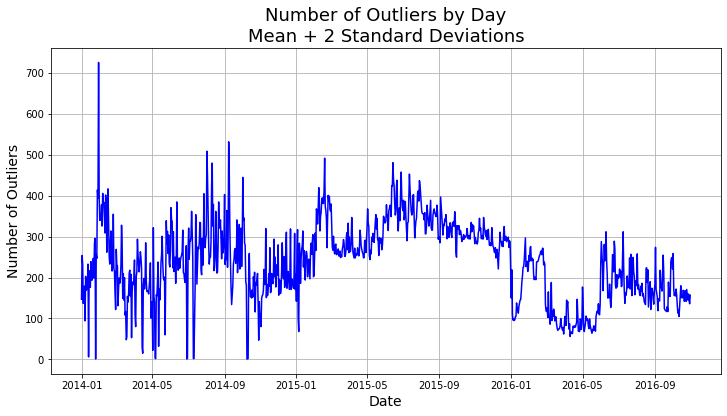

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(pd.DatetimeIndex(outliersByDay.index), 
        outliersByDay['Outliers'], 'b')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Outliers', fontsize=14)
plt.title('Number of Outliers by Day\nMean + 2 Standard Deviations', fontsize=18)
plt.grid(True)

In [57]:
NUM_CONSUMERS = len(data['CONS_NO'])

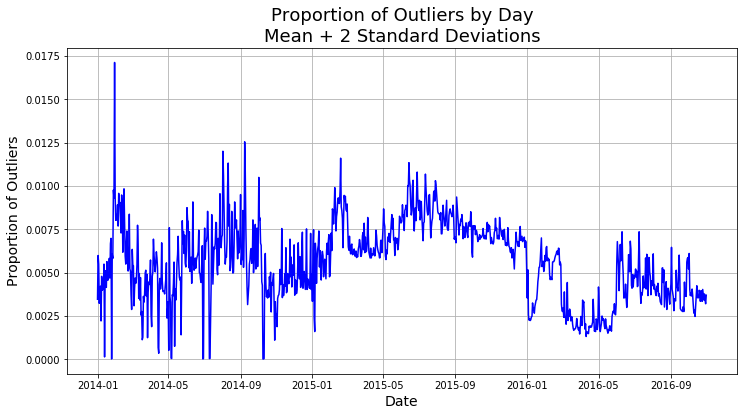

In [59]:
# Normalizing plot by number of consumers
plt.figure(figsize=(12, 6))
plt.plot(pd.DatetimeIndex(outliersByDay.index), 
        outliersByDay['Outliers']/ NUM_CONSUMERS, 'b')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Proportion of Outliers', fontsize=14)
plt.title('Proportion of Outliers by Day\nMean + 2 Standard Deviations', fontsize=18)
plt.grid(True)

### Interpretation
- Less than 0.0175% of the 42,372 kWh values reported by each consumer on each day are considered outliers. 
- Number of outliers seems to peak around February 2014, and then varies considerably.
- The number of values clearly small enough to not have a substantial effect on the data if scaled down to the maximum value. 

### Number of Outliers by Consumer

In [61]:
# What is the number of outlier kWhs for each consumer?
outliersByConsumer = pd.DataFrame(isOutlier.sum(axis=1))

In [62]:
outliersByConsumer.columns = ['Outliers']

In [63]:
outliersByConsumer.head()

,Outliers
0,0
1,0
2,0
3,0
4,0


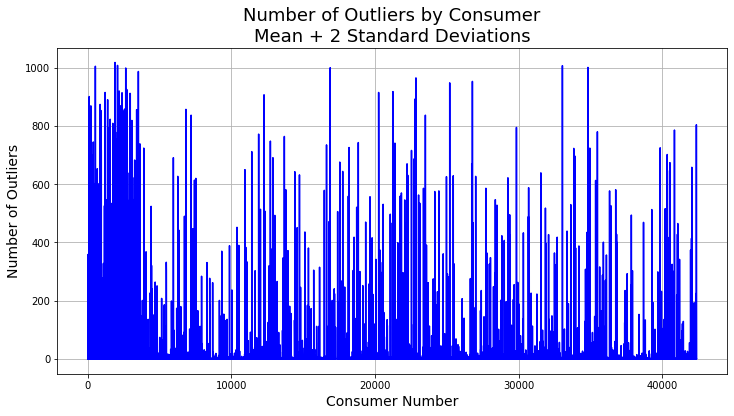

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(outliersByConsumer.index, 
        outliersByConsumer['Outliers'], 'b')
plt.xlabel('Consumer Number', fontsize=14)
plt.ylabel('Number of Outliers', fontsize=14)
plt.title('Number of Outliers by Consumer\nMean + 2 Standard Deviations', fontsize=18)
plt.grid(True)

In [68]:
NUM_DAYS = len(test.columns)

In [69]:
NUM_DAYS

1034

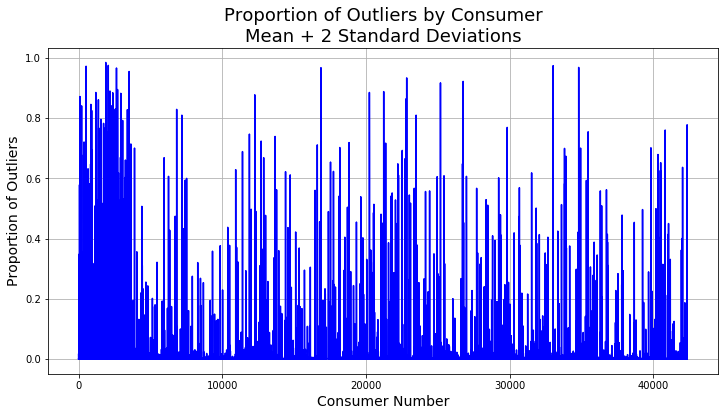

In [71]:
# Expressing plot as a percentage of 1,034 days - total number of readings reported by all consumers
plt.figure(figsize=(12, 6))
plt.plot(outliersByConsumer.index, 
        outliersByConsumer['Outliers']/NUM_DAYS, 'b')
plt.xlabel('Consumer Number', fontsize=14)
plt.ylabel('Proportion of Outliers', fontsize=14)
plt.title('Proportion of Outliers by Consumer\nMean + 2 Standard Deviations', fontsize=18)
plt.grid(True)

### Interpretation 
- This is alarming. There are far too many kWh values that could be considered outliers by Zheng's rule.
- Possible causes
    - ~~The sigma rule has been implemented incorrectly.~~
    - ~~The sigma rule needs to be adjusted: a value is an outlier only when it is 3 standard deviations above the mean (rather than 2).~~
- Outliers have been calculated using the mean and standard deviation of all kWhs of all consumers **per day**, not **per consumer**. 
- It doesn't make sense to apply a rule based around mean and standard deviation of values per day to values per consumer.
- Each consumer will have its own mean and standard deviation, which could be used to identify outliers through a similar approach.
- But this isn't done because there is far too much variation in the day-to-day consumption of a single user for a simplistic outlier detection method such as TSR to be useful.
    - A user could have an off-day, in which case they would tend to use more kWhs. Doesn't necessarily make this an outlier.
    - A user could have a long work day, and could use far fewer kWhs than usual. This, too, doesn't necessarily make this value an outlier.
- **TLDR**: Outlier identification has been done correctly.

## Replacing Outlier by Max Value
Zheng has also assumed that the maximum kWh value for any user on any given day cannot be greater than the threshold used to identify outliers on that day. Concretely, this means all outliers are mapped to
$$x_i = mean(X) + 2\times std(X)\\ \forall x_i > mean(X) + 2 \times std(X) $$

In [72]:
outliersRemoved = data

In [76]:
outliersRemoved[isOutlier] = np.nan

In [77]:
outliersRemoved.fillna(data.mean() + 2 * data.std(), inplace=True)

In [78]:
isOutlier_removed = outliersRemoved > (data.mean(axis=0) + 2 * data.std(axis=0))

In [79]:
outliersByDay = pd.DataFrame(isOutlier_removed.sum(axis=0))

In [80]:
outliersByDay.columns = ['Outliers']

## Missing Values - First and Last Columns

Replacing missing values in the first and last columns with 0. This is consistent with Zheng's rule: since we don't know the kWh value before the first day or after the last day, these values are as good as `NaN`. When the kWh value of either the previous or next day is `NaN`, the value on that day is assumed to be 0.

In [28]:
# Read data
data = pd.read_csv('./data-interpolated.csv')

In [29]:
# Missing values, extra index column
data.head()

,Unnamed: 0,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [30]:
# Missing values are only in the first and last columns
data.fillna(0, inplace=True)

In [31]:
data = data.drop('Unnamed: 0', axis=1)

In [32]:
value_counts = data.describe().loc['count'].drop('FLAG')

# Convert to dataframe so I don't have to deal with date formatting
value_counts_df = pd.DataFrame(value_counts)

In [33]:
value_counts_df.index = pd.DatetimeIndex(value_counts.index)

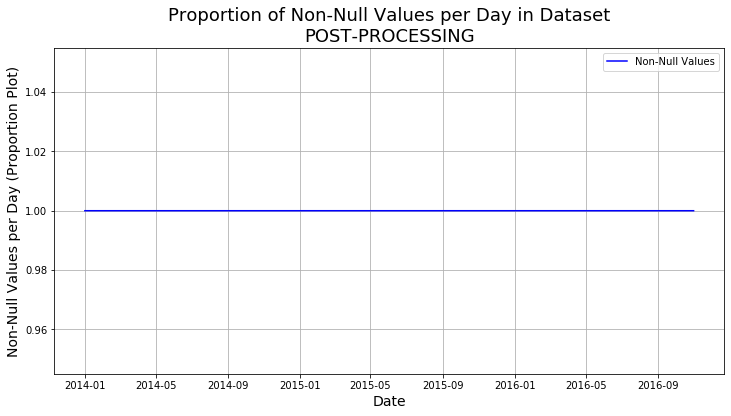

In [34]:
# Create plot of non-null values as proportion of all available values
plt.figure(figsize=(12, 6))
plt.plot(value_counts_df.index.to_pydatetime(), 
         value_counts_df.values / len(data[['CONS_NO']]), 
         'b-', label='Non-Null Values')
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
plt.title('Proportion of Non-Null Values per Day in Dataset\nPOST-PROCESSING', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.grid(); plt.legend()

No column in the dataset has missing values anymore. Can write to CSV, but must do so with the `index=False` argument because otherwise the write process appends an extra column with the row index.

In [36]:
data.to_csv('./data-final.csv', index=False)

## Outliers - By Consumer
It does not make sense to use the mean and standard deviation of kWh values of all consumers on each day to identify outlier kWh values. Every consumer has a different consumption pattern, and so what is an outlier for the majority of consumers may not necessarily be an outlier when considering the user's consumption pattern.

Need to identify outliers based on the mean and standard deviation in kWh values on a **consumer** basis instead of daily basis.

In [248]:
data = pd.read_csv('./data-final.csv')

In [249]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [250]:
kWhs = data.iloc[:, 2:]

In [251]:
kWhs.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


### Experimenting with First Row

In [335]:
# Extract first row
firstRow = kWhs.iloc[0, :]

In [336]:
# Calculate mean of first row w/o specifying aixs
firstRowMean = firstRow.mean()

In [337]:
# Confirming that axis = 0 gives same result 
assert firstRowMean == kWhs.iloc[0, :].mean(axis=0)

In [338]:
# For plotting
timestamps = pd.to_datetime(kWhs.columns)

In [339]:
# Making array of mean value and std dev for first row to plot
means = np.ones((len(kWhs.columns), 1)) * firstRow.mean()
std_threshold = np.ones((len(kWhs.columns), 1)) * firstRow.std() * 2

In [340]:
# Confirm both have same length before proceeding
assert len(means) == len(std_threshold)

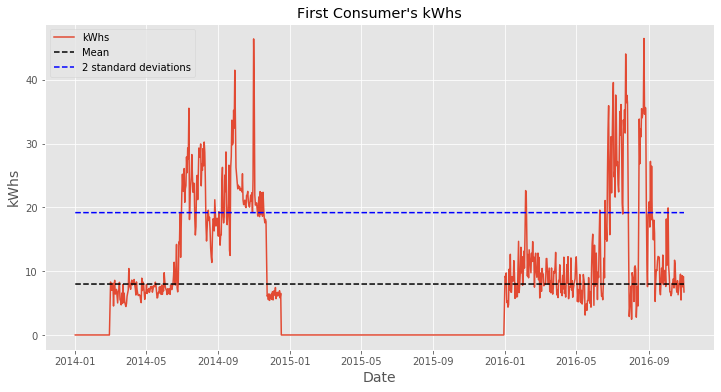

In [341]:
plt.figure(figsize=(12, 6))
plt.plot(timestamps, firstRow, label='kWhs')
plt.plot(timestamps, means, 'k--', label='Mean')
plt.plot(timestamps, std_threshold, 'b--', label='2 standard deviations')
plt.xlabel('Date', fontsize=14)
plt.ylabel('kWhs', fontsize=14)
plt.title('First Consumer\'s kWhs')
plt.legend()
plt.grid(True)

In [221]:
# Number of outliers
outliers = firstRow > (firstRow.mean() + 2 * firstRow.std())

In [222]:
outliers.shape

(1034,)

In [350]:
pd.DataFrame(outliers)

,0
2014-01-01,False
2014-01-02,False
2014-01-03,False
2014-01-04,False
2014-01-05,False
...,...
2016-10-27,False
2016-10-28,False
2016-10-29,False
2016-10-30,False


In [351]:
# Find values that are true
outliers.sum()

57

57 values out of 1,035 will be considered outliers according to this implementation.

### Outliers by Consumer

Will try to apply the column-wise outlier detection scheme on a row-wise basis.

In [23]:
data = pd.read_csv('./data-final.csv')

In [24]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [25]:
kWhs = data.iloc[:, 2:]

In [26]:
kWhs.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [27]:
meansByRow = kWhs.mean(axis=1)

In [28]:
meansByRow.describe()

count    42372.000000
mean         6.968539
std         35.049966
min          0.000000
25%          1.222592
50%          3.742183
75%          7.575947
max       3990.145068
dtype: float64

In [29]:
meansByRow.head()

0    7.988158
1    0.000000
2    2.501688
3    6.701586
4    8.229603
dtype: float64

In [30]:
stdevsByRow = kWhs.std(axis=1)

In [31]:
stdevsByRow.head()

0     9.591200
1     0.000000
2     5.490719
3    10.603029
4     5.942862
dtype: float64

In [32]:
stdevsByRow.describe()

count    42372.000000
mean        10.303124
std        259.078581
min          0.000000
25%          1.570575
50%          3.514617
75%          6.107265
max      30445.607718
dtype: float64

In [33]:
stdevsByRow.shape

(42372,)

In [34]:
meansByRow.shape

(42372,)

In [35]:
assert stdevsByRow.shape == meansByRow.shape

In [36]:
thresholds = meansByRow + 2 * stdevsByRow

In [37]:
firstRow = kWhs.iloc[0]

In [43]:
booleanMask = firstRow.apply(lambda kWh: True if kWh > thresholds[0] else False)

In [44]:
booleanMask.head()

2014-01-01    False
2014-01-02    False
2014-01-03    False
2014-01-04    False
2014-01-05    False
Name: 0, dtype: bool

In [45]:
thresholds[0]

27.170558255892598

In [42]:
firstRow.head()

2014-01-01    0.0
2014-01-02    0.0
2014-01-03    0.0
2014-01-04    0.0
2014-01-05    0.0
Name: 0, dtype: float64

In [46]:
np.sum(booleanMask)

57

### Using for loop with lambda expression

In [47]:
(NUM_CONSUMERS, NUM_DAYS) = kWhs.shape

In [49]:
print(f'Number of consumers: {NUM_CONSUMERS}')
print(f'Number of days: {NUM_DAYS}')

Number of consumers: 42372
Number of days: 1034


In [57]:
import time

In [61]:
outlierBooleanMask = np.zeros((NUM_CONSUMERS, NUM_DAYS))

In [67]:
t_start = time.time()
for i in range(0, NUM_CONSUMERS):
    outlierBooleanMask[i] = kWhs.iloc[i].apply(lambda kWh : True if kWh > thresholds[i] else False)
t_end = time.time()
print(t_end - t_start)

1051.6177952289581


In [70]:
pd.DataFrame(outlierBooleanMask).to_csv('./outlierBooleans.csv', index=False)

In [72]:
outlierDF = pd.DataFrame(outlierBooleanMask)

In [73]:
outlierDF.head()

,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
np.sum(outlierDF.iloc[0])

57.0

In [78]:
outlierCount = outlierDF.sum(axis=1)
outlierCount.head()

0    57.0
1     0.0
2    54.0
3    58.0
4    50.0
dtype: float64

In [81]:
outlierCount.describe()

count    42372.000000
mean        40.397645
std         22.949384
min          0.000000
25%         24.000000
50%         42.000000
75%         57.000000
max        197.000000
dtype: float64

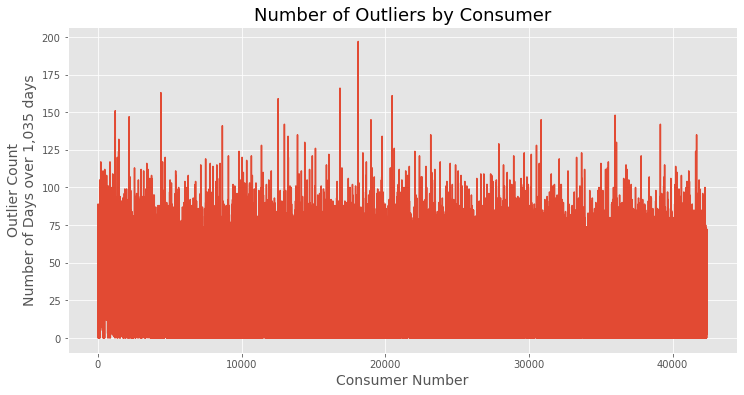

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(outlierCount);
plt.xlabel('Consumer Number', fontsize=14)
plt.ylabel('Outlier Count\nNumber of Days over 1,035 days', fontsize=14)
plt.title('Number of Outliers by Consumer', fontsize=18)
plt.grid(True)

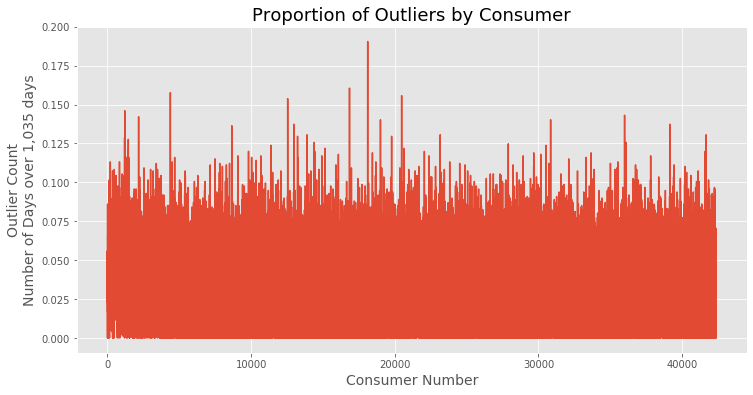

In [86]:
# Expressing as a proportion of 1,035 days
plt.figure(figsize=(12, 6))
plt.plot(outlierCount / NUM_DAYS);
plt.xlabel('Consumer Number', fontsize=14)
plt.ylabel('Outlier Count\nNumber of Days over 1,035 days', fontsize=14)
plt.title('Proportion of Outliers by Consumer', fontsize=18)
plt.grid(True)

In [89]:
outlierCount.describe()

count    42372.000000
mean        40.397645
std         22.949384
min          0.000000
25%         24.000000
50%         42.000000
75%         57.000000
max        197.000000
dtype: float64

### Interpretation
On average, ~41 of 1,035 kWhs reported by each consumer will be treated as outliers by Zheng's rule. The maximum and minimum number of kWh values identified as outliers for a single consumer are 197 and 0 respectively. 

The proportional plot shows that this rule, at most, will modify less than 20% of all kWhs per consumer by capping them at the max outlier limit.

In [108]:
outlierProportions = pd.DataFrame(outlierCount / NUM_DAYS)

In [109]:
minProportion = np.min(outlierProportions)
maxProportion = np.max(outlierProportions)
print(minProportion)
print(maxProportion)

0    0.0
dtype: float64
0    0.190522
dtype: float64


In [114]:
ranges = np.arange(0, 0.25, 0.05)

In [115]:
outlierProportionsGrouped = outlierProportions.groupby(pd.cut(outlierProportions.iloc[:, 0], ranges)).count()

In [116]:
outlierProportionsGrouped.columns =  ['Count']
outlierProportionsGrouped

,Count
0,
"(0.0, 0.05]",25650
"(0.05, 0.1]",14009
"(0.1, 0.15]",168
"(0.15, 0.2]",5


In [143]:
outlierDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 0 to 1033
dtypes: float64(1034)
memory usage: 334.3 MB


In [147]:
outliersByDay = pd.DataFrame(outlierDF.sum(axis=0))

In [151]:
outliersByDay.index = pd.to_datetime(kWhs.columns)

In [155]:
outliersByDay.columns = ['Outlier Count']

In [156]:
outliersByDay.head()

,Outlier Count
2014-01-01,1187.0
2014-01-02,900.0
2014-01-03,808.0
2014-01-04,875.0
2014-01-05,1016.0


Text(0.5, 1.0, 'Number of Outliers by Day')

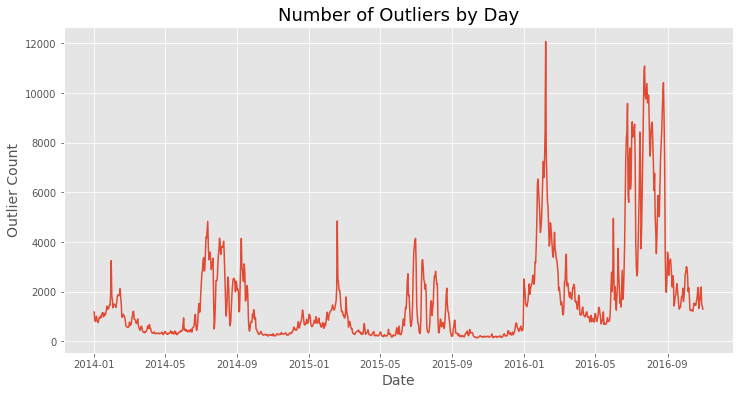

In [162]:
plt.figure(figsize=(12, 6))
plt.plot(outliersByDay)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Outlier Count', fontsize=14)
plt.title('Number of Outliers by Day', fontsize=18)

Text(0.5, 1.0, 'Proportion of Outliers by Day')

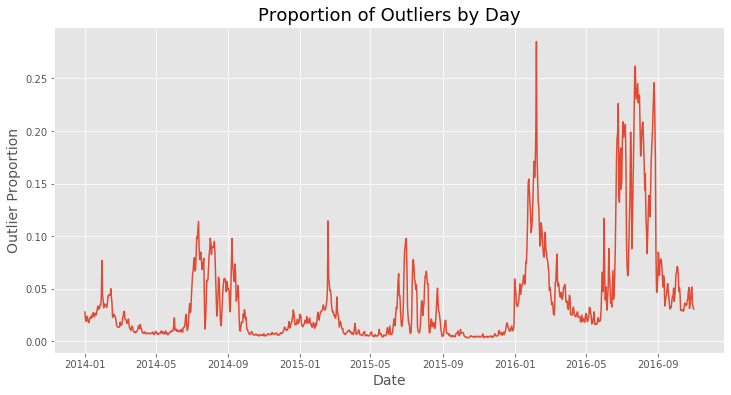

In [163]:
plt.figure(figsize=(12, 6))
plt.plot(outliersByDay / NUM_CONSUMERS)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Outlier Proportion', fontsize=14)
plt.title('Proportion of Outliers by Day', fontsize=18)

In [164]:
outliersByDay.describe()

,Outlier Count
count,1034.000000
mean,1655.443907
std,2010.091826
min,141.000000
25%,363.250000
50%,915.000000
75%,2072.750000
max,12079.000000


### Intepretation
When outliers are identified by applying the three sigma rule on a consumer basis, the number of outliers on any given day are at most 12,079 (which represents ~30% of all consumers) and at least 141 (which represents ~0.003 of all  consumers). On average, the number of outliers per day is 0.039.

In [169]:
ranges = np.arange(0, 0.35, 0.05)

In [174]:
Jupyter Notebook
FYP Assignment - Data Preprocessing
Last Checkpoint: 11 minutes ago
(unsaved changes)
Current Kernel Logo
Python 3 
File
Edit
View
Insert
Cell
Kernel
Widgets
Help

FYP Assignment 3 - Data Preprocessing
Exploratory data analysis, visualization, and preprocessing of Zheng's energy consumption dataset.

Exploratory Data Analysis
Reading Data
1
# Standard imports
2
import numpy as np
3
import pandas as pd
4
import matplotlib.pyplot as plt
5
import seaborn as sns
6
​
7
from matplotlib import style
8
style.use('ggplot')
9
%matplotlib inline
1
# Reading the entire dataset into a pandas dataframe - tractable because 167 MB
2
data = pd.read_csv('./data.csv')
Data Overview
1
data.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016/9/9
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB
Interpretation
42,372 rows in the dataset, which means there are 42,372 training examples.
1,036 columns in the dataset(!)
1 is CONS_NO: the unique identifier for consumers in the dataset. This is most likely an object.
Another column is an int64 - most likely the FLAG.
Remaining 1,034 columns are all kWhs, and are float64s, so won't have to be cast later on.
~340M MB of memory used. Even on my PM laptop, this isn't too much.
This means I can play around with the data on a mid-tier laptop without waiting too much.
Statistical Summary - Numerical Columns
Will examine the mean, std, min, max, and count for all columns except CONS_NO. This will also give me a good first look at the dataset.

1
# Save the description into a new dataframe to index counts for visualizing missing values
2
description_df = data.describe()
1
# Echo the dataframe
2
description_df
FLAG	2014/1/1	2014/1/10	2014/1/11	2014/1/12	2014/1/13	2014/1/14	2014/1/15	2014/1/16	2014/1/17	...	2016/9/28	2016/9/29	2016/9/3	2016/9/30	2016/9/4	2016/9/5	2016/9/6	2016/9/7	2016/9/8	2016/9/9
count	42372.000000	25870.000000	25912.000000	25911.000000	25912.00000	25912.000000	25912.000000	25915.000000	25924.000000	25925.000000	...	40544.000000	41482.000000	41915.000000	41151.000000	41906.000000	41873.000000	41850.000000	41967.000000	42044.000000	42027.00000
mean	0.085316	7.168735	6.954202	6.784099	7.08430	10.516470	7.219633	7.341512	7.160004	6.839875	...	8.836129	9.304656	10.758718	9.942215	11.173498	11.482926	11.656425	11.322680	11.015589	10.69165
std	0.279354	34.131237	40.017856	38.327058	31.98716	576.388348	34.703617	36.569049	36.916957	30.235396	...	52.371956	57.063621	88.039832	62.010381	94.267851	100.971180	118.369381	103.891111	100.614909	107.25814
min	0.000000	0.000000	0.000000	0.000000	0.00000	0.000000	0.000000	0.000000	0.000000	0.000000	...	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.00000
25%	0.000000	0.000000	0.000000	0.000000	0.00000	0.000000	0.000000	0.000000	0.000000	0.000000	...	0.660000	0.820000	0.880000	0.880000	0.900000	0.920000	0.940000	0.910000	0.910000	0.90000
50%	0.000000	3.310000	2.870000	2.900000	3.35000	3.440000	3.295000	3.470000	3.130000	3.250000	...	4.380000	4.670000	5.010000	4.820000	5.150000	5.110000	5.190000	5.110000	5.020000	4.93000
75%	0.000000	8.910000	8.170000	8.210000	8.76000	8.620000	8.740000	8.900000	8.780000	8.520000	...	9.300000	9.380000	10.740000	9.700000	11.380000	11.430000	11.600000	11.300000	10.730000	10.28000
max	1.000000	3318.000000	3966.000000	4392.000000	3414.00000	92713.900000	3167.000000	3960.000000	3654.000000	3306.000000	...	6324.000000	6990.000000	14640.000000	6672.000000	16320.000000	17100.000000	21210.000000	17940.000000	16710.000000	18570.00000
8 rows × 1035 columns

Interpretation
There are far too many columns in the dataset to identify missing, null, or erroneous values by inspection.
There is a problem with the dates - they are not in the right order. 10th January, 2014 follows 1st January, 2014. Is this because the columns are being treated as strings?
There are indeed 42,372 consumers, as shown in the count for the FLAG
Missing values aplenty in the first few columns.
FLAG is the target variable: what we will be trying to predict.
Max and min values for the FLAG column are 0 and 1, which confirms that there is no erroneous value (negative flag, or third category of flag) in the target column.
All other columns (dates) are features: what we will be using to make classifications.
mean of FLAG is very close to 0, which suggests this is a right skewed binary distribution in which more consumers have FLAG of 0 as opposed to 1.
TODO: Ask Dr. AB how to intepret standard deviation of FLAG.
No missing values in the FLAG column since count is same as number of rows in dataset.
Checking for Negative kWhs
Negative value for kWhs is erroneous data. Need to identify if such a value exists. Can't do this by inspection of head. Have to do it programmatically.

1
# Extract kWh values into a numpy array to check for negative values
2
kWh_vals = data.iloc[:, 2:].values
3
​
4
# Check that the numpy array has one row per consumer, one column per date
5
assert kWh_vals.shape == (len(data), len(data.columns[2:]))
1
# Is there any negative value in the kWhs?
2
np.any(data.iloc[:, 2:] < 0) == True
False
Interpretation
This confirms that while there may be NaNs in the kWhs, there are no negative kWhs i.e. erroneous values. This is one less thing to worry about when preprocessing the data later.

Visualizing Missing Values
We've established that there are no negative kWh readings in the dataset, which means there are only two types of values left for the kWh: positive float64 or NaN aka missing values.

Since there are more than 1,000 columns in the dataset, using head to visualize missing values in each column (actually on each day) is intractable.

Instead, creating a new dataframe of non-null values in each column of the dataset and plotting it to show the trend in the number of missing values in the dataset.

This plot will not show a chronological trend because the columns have not been sorted yet.

1
# Extract counts for all dates - this will then be plotted to visualize missing values
2
value_counts = description_df.loc['count'].drop('FLAG')
1
"""Create an array of ones scaled by the max number of value counts - this is the maximum
2
number of kWh values we could have at any given date. Making a list helps me plot this 
3
as a straight line on a graph as a threshold"""
4
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)
1
# Create plot of non-null values
2
plt.figure(figsize=(12, 6))
3
plt.plot(value_counts, 'b-', label='Non-Null Values')
4
plt.plot(max_threshold, 'k--', label='100% Available')
5
plt.plot(0.75 * max_threshold, 'g--', label='75% Available')
6
plt.plot(0.50 * max_threshold, 'y--', label='50% Available')
7
plt.plot(0.25 * max_threshold, 'r--', label='25% Available')
8
plt.xticks([]) # Do not want indices or dates for now
9
plt.ylabel('Non-Null Values per Day', fontsize=14)
10
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
11
plt.grid(); plt.legend()
<matplotlib.legend.Legend at 0x12797c2e8>

Interpretation
There is clearly one day when the number of non-null values drop to ~0. This day should be dropped from the data unless we can figure out how to fill in these missing values using data from previous and next days/weeks.

On most days, the number of non-null values is between 50% and 75% of the total number of consumers in the dataset. Near complete set of readings is only available towards the end of the dataset i.e in 2016.

There is also no day where all 42,372 consumers reported a non-null reading.

1
# Minimum number of non-null kW readings recorded on a day
2
min_readings = np.min(value_counts)
3
max_readings = np.max(value_counts) 
4
print(f"Min Readings: {min_readings}\nMax Readings: {max_readings}")
5
​
6
# What is the index of the column where minimum non-null value count occurs?
7
idx_min = value_counts.idxmin()
Min Readings: 15.0
Max Readings: 42044.0
1
# What is the date of the day with the 
2
idx_min
'2014/10/3'
1
# Display statistics for this day
2
data[[idx_min]].describe()
2014/10/3
count	15.000000
mean	484.908667
std	772.293554
min	15.300000
25%	50.300000
50%	144.000000
75%	334.500000
max	2463.000000
Interpretation
The number of non-null values in the dataset dropped to 15 on 3rd October, 2014.

TODO: Ask Dr. AB whether we should drop this column from the sequence entirely.

Class Distribution
1
# Count non-null values in each column based on FLAG column value
2
grouped_by_flag = data.groupby('FLAG').count()
3
grouped_by_flag
CONS_NO	2014/1/1	2014/1/10	2014/1/11	2014/1/12	2014/1/13	2014/1/14	2014/1/15	2014/1/16	2014/1/17	...	2016/9/28	2016/9/29	2016/9/3	2016/9/30	2016/9/4	2016/9/5	2016/9/6	2016/9/7	2016/9/8	2016/9/9
FLAG																					
0	38757	23742	23773	23773	23773	23772	23774	23778	23781	23782	...	37121	38025	38413	37674	38403	38374	38341	38459	38544	38526
1	3615	2128	2139	2138	2139	2140	2138	2137	2143	2143	...	3423	3457	3502	3477	3503	3499	3509	3508	3500	3501
2 rows × 1035 columns

1
# Extract the number of consumers
2
grouped_by_flag[['CONS_NO']]
CONS_NO
FLAG	
0	38757
1	3615
1
# What does this mean in terms of percentage of total consumers?
2
print("%age distribution of classes\nb")
3
print(grouped_by_flag[['CONS_NO']]/len(data[['CONS_NO']]))
%age distribution of classes
b
       CONS_NO
FLAG          
0     0.914684
1     0.085316
1
# Countplot will distribute values according to class
2
sns.countplot(x='FLAG', data=data)
3
plt.xlabel('FLAG', fontsize=14)
4
plt.ylabel('Count', fontsize=14)
5
plt.title('Class Distribution', fontsize=18)
Text(0.5, 1.0, 'Class Distribution')

Interpretation
This is an unbalanced classification problem - there is a 91.5-8.5% split between negative and positive (target) class in the dataset. This corroborates earlier finding of right skewed distribution and low mean.

Visualizing Missing Values per Category
Do regular consumers have more or fewer missing values than thieves? Are thieves bypassing their electricity meters more than regular consumers?

1
# Echoing because I'm lazy
2
grouped_by_flag.head()
CONS_NO	2014/1/1	2014/1/10	2014/1/11	2014/1/12	2014/1/13	2014/1/14	2014/1/15	2014/1/16	2014/1/17	...	2016/9/28	2016/9/29	2016/9/3	2016/9/30	2016/9/4	2016/9/5	2016/9/6	2016/9/7	2016/9/8	2016/9/9
FLAG																					
0	38757	23742	23773	23773	23773	23772	23774	23778	23781	23782	...	37121	38025	38413	37674	38403	38374	38341	38459	38544	38526
1	3615	2128	2139	2138	2139	2140	2138	2137	2143	2143	...	3423	3457	3502	3477	3503	3499	3509	3508	3500	3501
2 rows × 1035 columns

1
# Get regular consumer's non-null values. 1st column onwards selects counts on each day
2
reg_non_null_counts = grouped_by_flag.iloc[0, 1:] 
3
thieves_non_null_counts = grouped_by_flag.iloc[1, 1:]
1
# Plot the number of non-null values per day for each class along with total number of non-null values per day
2
plt.figure(figsize=(12, 6))
3
plt.plot(reg_non_null_counts, 'b-', label='Regular')
4
plt.plot(thieves_non_null_counts, 'r-', label='Thieves');
5
plt.plot(value_counts, 'k-', label='Combined')
6
plt.title('Non-Null Value Counts against Day by Flag', fontsize=18)
7
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
8
plt.ylabel('Non-Null Value Count', fontsize=14); plt.grid(True); plt.legend()
<matplotlib.legend.Legend at 0x127899240>

Interpretation
This plot shows that there is a lot more variation in the number of missing values for regular consumers than in those of thieves. The number of non-null values in thieves is more or less a flat line with an occasional jump here and there.

However, this may just be because the proportion of thief values in the dataset is very small, so on the scale of this graph, it gives the false impression that there isn't much variation. There could be a substantial number of missing thief values as a percentage of the total thief values. Needs further investigation.

This would also explain why the overall trend follows the pattern of the number of non-null regular consumers per day so closely. The number of regular consumers' non-null values is dominating the overall number of missing values.

1
# Total number of consumers - found using number of unique consumer numbers
2
total_consumers = data[['CONS_NO']].nunique()
3
print("Total Consumers: ", total_consumers)
4
​
5
# Total number of regular consumers and thieves - found by grouping by flag
6
total_reg_consumers = grouped_by_flag[['CONS_NO']].loc[0]
7
total_thieves = grouped_by_flag[['CONS_NO']].loc[1]
8
​
9
print("Regular Consumers: ", total_reg_consumers)
10
print("Thieves: ", total_thieves)
Total Consumers:  CONS_NO    42372
dtype: int64
Regular Consumers:  CONS_NO    38757
Name: 0, dtype: int64
Thieves:  CONS_NO    3615
Name: 1, dtype: int64
1
# Will use these constants to plot non-null values as proportion of their respective category
2
plt.figure(figsize=(12, 6))
3
plt.plot(reg_non_null_counts / float(total_reg_consumers), 'b-', label='Regular')
4
plt.plot(thieves_non_null_counts / float(total_thieves), 'r-', label='Thieves');
5
plt.plot(value_counts / float(total_consumers), 'k-', label='Combined')
6
plt.title('Proportions of Non-Null Value Counts against Day by Category', fontsize=18)
7
plt.xticks([]); plt.xlabel('Day (unsorted)', fontsize=14);
8
plt.ylabel('Non-Null Value Count (Proportion)', fontsize=14); plt.grid(True); plt.legend()
<matplotlib.legend.Legend at 0x1279abbe0>

Interpretation
This graph gives a much better indication of the number of missing values per day for the entire dataset (shown in the black line) as well as for individual categories (thieves and regular consumers shown in red and blue respectively).

It confirms my suspicion that the apparent lack of variation in number of non-null thief values was only due to the scale of the raw thief counts being orders of magnitude smaller than those of regular consumers and the entire dataset. Once the number of non-null kWh readings for thieves per day are scaled by the maximum number of values that could have been measured, the trend is very similar to the entire dataset and to the regular consumers.

Ideas to Consider

Missing Values As Features: There is a significant difference (~-0.1 units) between the proportion of non-null values for thieves and regular consumers. Could this mean that the absence of kWh readings can be a possible feature for distinguishing the two?
Why: why is there a difference between the proportion of non-null values for thieves and regular consumers? Could this be due to thieves bypassing their meters? Is this relevant?
Rearranging Columns Chronologically (Test)
The most glaring issue in the dataset right now, other than the large number of NaNs is the fact that the dataset's columns are not sorted chronologically. This isn't a problem with pandas or the way it reads values from a CSV: the same sequence of columns is present in the original CSV when examined with Excel.

1
# What is the data type of the columns?
2
cols = data.columns.tolist()
3
​
4
# Output the values starting from the 2nd index 
5
print(cols[2:10])
6
​
7
# What is the type of each of these dates? Is it a string or a datetime?
8
print(type(cols[2]))
['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13', '2014/1/14', '2014/1/15', '2014/1/16']
<class 'str'>
Interpretation
The dates are stored as strings and not as datetime objects, which would explain why they appear to be out of order: they are sorted lexicographically rather than chronologically.

The solution is to convert each column header from string to datetime, and then sort the dataset according to datetime values in ascending order. This will get rid of the lack of sequence.

1
# Making a copy of the dataset to test modification of columns
2
new_df = data.iloc[:,:]
1
# Should be the same as the original dataset
2
new_df.describe()
FLAG	2014/1/1	2014/1/10	2014/1/11	2014/1/12	2014/1/13	2014/1/14	2014/1/15	2014/1/16	2014/1/17	...	2016/9/28	2016/9/29	2016/9/3	2016/9/30	2016/9/4	2016/9/5	2016/9/6	2016/9/7	2016/9/8	2016/9/9
count	42372.000000	25870.000000	25912.000000	25911.000000	25912.00000	25912.000000	25912.000000	25915.000000	25924.000000	25925.000000	...	40544.000000	41482.000000	41915.000000	41151.000000	41906.000000	41873.000000	41850.000000	41967.000000	42044.000000	42027.00000
mean	0.085316	7.168735	6.954202	6.784099	7.08430	10.516470	7.219633	7.341512	7.160004	6.839875	...	8.836129	9.304656	10.758718	9.942215	11.173498	11.482926	11.656425	11.322680	11.015589	10.69165
std	0.279354	34.131237	40.017856	38.327058	31.98716	576.388348	34.703617	36.569049	36.916957	30.235396	...	52.371956	57.063621	88.039832	62.010381	94.267851	100.971180	118.369381	103.891111	100.614909	107.25814
min	0.000000	0.000000	0.000000	0.000000	0.00000	0.000000	0.000000	0.000000	0.000000	0.000000	...	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.000000	0.00000
25%	0.000000	0.000000	0.000000	0.000000	0.00000	0.000000	0.000000	0.000000	0.000000	0.000000	...	0.660000	0.820000	0.880000	0.880000	0.900000	0.920000	0.940000	0.910000	0.910000	0.90000
50%	0.000000	3.310000	2.870000	2.900000	3.35000	3.440000	3.295000	3.470000	3.130000	3.250000	...	4.380000	4.670000	5.010000	4.820000	5.150000	5.110000	5.190000	5.110000	5.020000	4.93000
75%	0.000000	8.910000	8.170000	8.210000	8.76000	8.620000	8.740000	8.900000	8.780000	8.520000	...	9.300000	9.380000	10.740000	9.700000	11.380000	11.430000	11.600000	11.300000	10.730000	10.28000
max	1.000000	3318.000000	3966.000000	4392.000000	3414.00000	92713.900000	3167.000000	3960.000000	3654.000000	3306.000000	...	6324.000000	6990.000000	14640.000000	6672.000000	16320.000000	17100.000000	21210.000000	17940.000000	16710.000000	18570.00000
8 rows × 1035 columns

1
# Extract the date columns only - not `FLAG` or `CONS_NO`
2
columns = new_df.columns[2:]
1
# Convert to datetime in specified format
2
new_cols = pd.to_datetime(columns)
1
# Attempt to sort after casting to datetime
2
new_cols.sort_values()
DatetimeIndex(['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10',
               ...
               '2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31'],
              dtype='datetime64[ns]', length=1034, freq=None)
1
# Checking indices of original columns list to identify where dates begin
2
print(new_df.columns[:2])
3
print(new_df.columns[2:])
Index(['CONS_NO', 'FLAG'], dtype='object')
Index(['2014/1/1', '2014/1/10', '2014/1/11', '2014/1/12', '2014/1/13',
       '2014/1/14', '2014/1/15', '2014/1/16', '2014/1/17', '2014/1/18',
       ...
       '2016/9/28', '2016/9/29', '2016/9/3', '2016/9/30', '2016/9/4',
       '2016/9/5', '2016/9/6', '2016/9/7', '2016/9/8', '2016/9/9'],
      dtype='object', length=1034)
Extract first two columns (CONS_NO and FLAG) because they don't need to be cast to datetime. Then extract the actual date strings (column indices 2 onwards) and cast them to datetime and extract only the date using the date attribute - without it, all column names have an unnecessary 00:00:00 at the end.

Must concatenate both sets of columns as lists and then assign the result to the new dataframe's columns.

1
# Concatenate original `CONS_NO` and `FLAG` with **UNSORTED** datetime column names
2
new_df.columns = new_df.columns[:2].tolist() + pd.to_datetime(new_df.columns[2:]).date.tolist()
1
# Did it work?
2
new_df.head()
CONS_NO	FLAG	2014-01-01	2014-01-10	2014-01-11	2014-01-12	2014-01-13	2014-01-14	2014-01-15	2014-01-16	...	2016-09-28	2016-09-29	2016-09-03	2016-09-30	2016-09-04	2016-09-05	2016-09-06	2016-09-07	2016-09-08	2016-09-09
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.12	9.96	16.92	7.60	27.22	18.05	26.47	18.75	17.84	14.92
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	6.50	9.99	11.78	18.59	26.80	18.57	14.59	12.82	19.37	15.92
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	3.42	3.81	4.58	3.56	4.25	3.86	3.53	...	17.77	10.37	15.32	13.51	12.23	14.68	16.35	18.14	18.41	17.31
5 rows × 1036 columns

It worked. Now to sort the columns in ascending order.

1
# Extract list of column names
2
dt_cols = new_df.columns[2:]
3
​
4
# Sort them in ascending order
5
sorted_dt_cols = dt_cols.sort_values()
6
​
7
# Did it work?
8
print(sorted_dt_cols[:25]) 
Index([2014-01-01, 2014-01-02, 2014-01-03, 2014-01-04, 2014-01-05, 2014-01-06,
       2014-01-07, 2014-01-08, 2014-01-09, 2014-01-10, 2014-01-11, 2014-01-12,
       2014-01-13, 2014-01-14, 2014-01-15, 2014-01-16, 2014-01-17, 2014-01-18,
       2014-01-19, 2014-01-20, 2014-01-21, 2014-01-22, 2014-01-23, 2014-01-24,
       2014-01-25],
      dtype='object')
1
# Extract the kW into a separate df
2
kw_df = new_df.iloc[:, 2:]
1
kw_df.head()
2014-01-01	2014-01-10	2014-01-11	2014-01-12	2014-01-13	2014-01-14	2014-01-15	2014-01-16	2014-01-17	2014-01-18	...	2016-09-28	2016-09-29	2016-09-03	2016-09-30	2016-09-04	2016-09-05	2016-09-06	2016-09-07	2016-09-08	2016-09-09
0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.12	9.96	16.92	7.60	27.22	18.05	26.47	18.75	17.84	14.92
1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
3	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	6.50	9.99	11.78	18.59	26.80	18.57	14.59	12.82	19.37	15.92
4	2.9	3.42	3.81	4.58	3.56	4.25	3.86	3.53	3.41	0.85	...	17.77	10.37	15.32	13.51	12.23	14.68	16.35	18.14	18.41	17.31
5 rows × 1034 columns

1
# Extract the consumer number and flags
2
cons_flags_df = new_df.iloc[:, :2]
3
​
4
# Extract the kWhs separately
5
kWhs_df = new_df.iloc[:, 2:]
6
​
7
# Sort the kWhs dataframe according to their columns
8
kWhs_df.sort_index(axis=1, inplace=True, ascending=True)
9
​
10
# Did it work?
11
kWhs_df.head()
2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	2014-01-09	2014-01-10	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	3.53	3.42	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1034 columns

1
# For merging the two dataframes together by INNER JOIN, use CONS_NO as key
2
kWhs_df.insert(0, 'CONS_NO', new_df[['CONS_NO']])
1
kWhs_df.head()
CONS_NO	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	2014-01-09	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	3.53	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1035 columns

1
# Join the dataframes using CONS_NO as key
2
sorted_df = pd.merge(left=cons_flags_df, right=kWhs_df, how='left', 
3
                    on='CONS_NO', left_index=True, right_index=False)
1
# Did it work?
2
sorted_df.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

1
# Compare to original data
2
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-10	2014-01-11	2014-01-12	2014-01-13	2014-01-14	2014-01-15	2014-01-16	...	2016-09-28	2016-09-29	2016-09-03	2016-09-30	2016-09-04	2016-09-05	2016-09-06	2016-09-07	2016-09-08	2016-09-09
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.12	9.96	16.92	7.60	27.22	18.05	26.47	18.75	17.84	14.92
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	6.50	9.99	11.78	18.59	26.80	18.57	14.59	12.82	19.37	15.92
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	3.42	3.81	4.58	3.56	4.25	3.86	3.53	...	17.77	10.37	15.32	13.51	12.23	14.68	16.35	18.14	18.41	17.31
5 rows × 1036 columns

1
# Save to a new CSV file that can be loaded in future sessions
2
# `index` = False means data won't have an additional col of [0, 1, 2, ..., 42371]
3
sorted_df.to_csv('./sorted_data.csv', index=False)
Recap of Sorting Workflow
Separate into 2 dataframes - the first being CONS_NO and FLAG, and the second being kWhs
Including CONS_NO in both because it helps me join them using CONS_NO as a key.
Do not include the CONS_NO with the kWhs at first. Will be done later.
Extract column names from the kWhs dataframe and cast them to datetime objects.
Drop the time, only the date is necessary.
Reassign the column names. Don't save them into a separate variable.
Use the sort_index method on the kWh dataframe to reorganize columns in chronological order.
Insert the CONS_NO column in the sorted/rearranged kWh dataframe.
Can insert it at any location, but I prefer to use the first column because it is a key.
This will be used as a key for merging the constituent dataframes together.
Use merge to perform an inner join on the two dataframes using the CONS_NO column as a key. This eliminates any risk of the rows being combined in the wrong order, or being rearranged due to mismatches.
Interpreter was displaying a warning which said something about sorting rows because of a mismatch.
Inner join with merge avoids this issue entirely.
Missing Values in Sorted Data
Now that data has been sorted, we can try and figure out a trend in the number of missing values per day.

1
data = pd.read_csv('./sorted_data.csv')
1
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

1
# Extracting number of non-null values per day
2
value_counts = data.describe().loc['count'].drop('FLAG')
3
​
4
# Defining line that will be scaled to create thresholds in non-null plot
5
max_threshold = np.ones(len(value_counts)) * np.max(value_counts)
1
# Convert to dataframe so I don't have to deal with date formatting
2
value_counts_df = pd.DataFrame(value_counts)
1
# Create plot of non-null values
2
plt.figure(figsize=(12, 6))
3
plt.plot(value_counts_df.index.to_pydatetime(), 
4
         value_counts_df.values, 'b-', label='Non-Null Values')
5
plt.plot(value_counts_df.index.to_pydatetime(), 
6
    max_threshold, 'k--', label='100% Available')
7
plt.plot(value_counts_df.index.to_pydatetime(), 
8
         0.75 * max_threshold, 'g--', label='75% Available')
9
plt.plot(value_counts_df.index.to_pydatetime(), 
10
         0.50 * max_threshold, 'y--', label='50% Available')
11
plt.plot(value_counts_df.index.to_pydatetime(), 
12
         0.25 * max_threshold, 'r--', label='25% Available')
13
plt.xlabel('Date', fontsize=14)
14
plt.ylabel('Non-Null Values per Day', fontsize=14)
15
plt.title('Non-Null Values per Day in Dataset', fontsize=18)
16
plt.grid(); plt.legend()
<matplotlib.legend.Legend at 0x124f8f160>

1
# Create plot of non-null values as proportion of all available values
2
plt.figure(figsize=(12, 6))
3
plt.plot(value_counts_df.index.to_pydatetime(), 
4
         value_counts_df.values / len(data[['CONS_NO']]), 
5
         'b-', label='Non-Null Values')
6
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
7
plt.title('Proportion of Non-Null Values per Day in Dataset', fontsize=18)
8
plt.xlabel('Date', fontsize=14)
9
plt.grid(); plt.legend()
<matplotlib.legend.Legend at 0x124f48828>

Interpretation
Now that the data has been sorted chronologically, we can see there is a trend in the number of missing values with time.

Number of non-missing values increases to 30k by late 2014, drops to 15 in 10/2014, and then rises back again.
It then declines steadily to the beginning of 2016.
From the beginning of 2016, the number of non-null values is virutally the same as the max number of consumers (~99%).
For the majority of the dates, the number of non-null values is between 50 and 75%.
Missing Values per Consumer
Now that we've visualized the trend in the number of missing values per day, we're going to look at the number of missing values per consumer. That is, how many missing values did each consumer report across the 1,034 days that data was recorded?

1
consumer_non_null_vals = data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:])
1
plt.figure(figsize=(20, 8))
2
plt.plot(consumer_non_null_vals, linewidth=0.5)
3
plt.xlabel('Consumer Index', fontsize=14)
4
plt.ylim([0.6, 1])
5
plt.ylabel('Days Reported (percentage)', fontsize=14)
6
plt.title('Number of Non-Null kWhs per Consumer', fontsize=18)
7
plt.grid()

1
print("Minimum number of values: ", np.min(consumer_non_null_vals))
2
print("Maximum number of values: ", np.max(consumer_non_null_vals))
Minimum number of values:  0.0009671179883945841
Maximum number of values:  1.0
1
0.000967 * 1035
1.000845
Interpretation
Almost all consumers have reported a non-null value for at least 70% of the days.

Very few consumers have reported near to 42,372 values.

One consumer has reported NaNs on less than 0.0009% of days i.e. exactly 1 of 1,035 days.

This plot doesn't tell us very much. Need to aggregate consumer values.

Aggregating Consumers by Missing Values
1
data = pd.read_csv('./sorted_data.csv')
1
consumer_non_nulls = pd.DataFrame(data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:]))
1
ranges = np.arange(0, 1.1, 0.1)
1
consumer_grouped_non_nulls = consumer_non_nulls.groupby(pd.cut(consumer_non_nulls.iloc[:, 0], ranges)).count()
1
consumer_grouped_non_nulls.columns =  ['Count']
1
consumer_grouped_non_nulls
Count
0	
(0.0, 0.1]	20997
(0.1, 0.2]	4614
(0.2, 0.3]	2383
(0.3, 0.4]	1706
(0.4, 0.5]	1488
(0.5, 0.6]	552
(0.6, 0.7]	1114
(0.7, 0.8]	9324
(0.8, 0.9]	114
(0.9, 1.0]	80
1
num_consumers = len(data['CONS_NO'])
1
# First plot is logarithmic values
2
plt.figure(figsize=(8, 6))
3
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
4
       height=np.log(consumer_grouped_non_nulls['Count']),
5
       width=-0.05, linewidth=0.1, align='edge')
6
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
7
plt.ylabel('Logarithm(Number of Consumers)', fontsize=14)
8
plt.title('Number of Consumers against %age of \nnon-null readings over 1,035 days\nLogarithmic Graph', fontsize=18)
9
plt.grid(True)
10
plt.tight_layout()
11
​
12
# Second plot is raw count as a percentage of all consumers
13
plt.figure(figsize=(8, 6))
14
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
15
        height=consumer_grouped_non_nulls['Count'] / num_consumers, width=-0.05,
16
        linewidth=0.1, align='edge')
17
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
18
plt.ylabel('%Age of Consumers', fontsize=14)
19
plt.title('%Age of Consumers against %age of \nnon-null readings over 1,035 days', fontsize=18)
20
plt.grid(True)
21
​
22
plt.tight_layout()


Interpretation
~50% of the consumers in the dataaset have reported non-null kWh readings for <= 10% of 1,035 days.
The next largest common percentage is between 70% and 80%: this means 22% of consumers have reported non-null values on at least 80% of all days.
Replacing NaNs
In their paper, Zheng et. al (2017) have used the following approach for replacing missing values. The kWhs consumed on a day 𝑖 are denoted by 𝑥𝑖. If 𝑥𝑖 = NaN, then

Case 1: Previous and Next kWhs both Defined
If 𝑥𝑖−1,𝑥𝑖+1∉ NaN, then
𝑥𝑖=𝑥𝑖+1+𝑥𝑖−12
. The current day's kWhs are the average of the kWhs consumed on the next and previous days.

Case 2: Previous or Next kWhs Undefined
If 𝑥𝑖+1∈ NaN OR 𝑥𝑖−1∈ NaN, then
𝑥𝑖=0
. The authors have assumed that if either of the next or previous days' kWhs are undefined, we will assume the current day's kWhs to be 0.

In all other cases, the authors make no change to the value of 𝑥𝑖.

1
import time
1
# Reading data
2
t_0 = time.time()
3
data = pd.read_csv('./sorted_data.csv')
4
elapsed = time.time() - t_0
5
print(elapsed)
6.874460220336914
1
# Extract kWhs as numpy array
2
kWhs = data.iloc[:, 2:].values
1
# Confirm correct data extracted and 
2
rows, cols = kWhs.shape
3
print("Rows (number of consumers)\t: ", rows)
4
print("Columns (number of days)\t: ", cols)
Rows (number of consumers)	:  42372
Columns (number of days)	:  1034
1
t_0 = time.time()
2
for row in list(range(0, rows)):
3
    # Can't modify the first and last columns so no point checking for them
4
    for col in list(range(1, cols - 1)):
5
        # Only for the `NaN`s
6
        if (np.isnan(kWhs[row, col])):
7
            # If NaN today OR tomorrow, set to 0.0
8
            if (np.isnan(kWhs[row, col - 1]) or np.isnan(kWhs[row, col + 1])):
9
                kWhs[row, col] = 0.0
10
​
11
            # If defined today AND tomorrow, set to mean - isnfinite practically same as ~isnan
12
            elif (np.isfinite(kWhs[row, col - 1] and np.isfinite(kWhs[row, col + 1]))):
13
                kWhs[row, col] = np.mean([kWhs[row, col - 1], kWhs[row, col + 1]])
14
​
15
# How long did this take lol
16
t_f = time.time()
17
(t_f - t_0) / 60
2.6468756993611655
1
# Replace old data with new data
2
data.iloc[:, 2:] = kWhs
1
# Did it work?
2
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

Visualizing Effect of Interpolation - Per Day Non-Nulls
1
# Extracting number of non-null values per day
2
value_counts = data.describe().loc['count'].drop('FLAG')
3
​
4
# Convert to dataframe so I don't have to deal with date formatting
5
value_counts_df = pd.DataFrame(value_counts)
1
value_counts_df.index = pd.DatetimeIndex(value_counts.index)
1
# Create plot of non-null values as proportion of all available values
2
plt.figure(figsize=(12, 6))
3
plt.plot(value_counts_df.index.to_pydatetime(), 
4
         value_counts_df.values / len(data[['CONS_NO']]), 
5
         'b-', label='Non-Null Values')
6
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
7
plt.title('Proportion of Non-Null Values per Day in Dataset\nPOST-PROCESSING', fontsize=18)
8
plt.xlabel('Date', fontsize=14)
9
plt.grid(); plt.legend()
<matplotlib.legend.Legend at 0x11831c6a0>

Interpretation
The interpolation seems to have worked. Now there are virtually no missing values on each day.
The sharp drops at 2014-01-01 and 2016-12-31 are because these are the first and last dates in the dataset respectively, and as per Zheng et. al's rules, no interpolation has been defined for values on these days. Thus, these days do still contain missing values.
TODO
How to deal with this? Drop these columns? Will 2 days make a difference when we have data for 1,034?
Is there a better way to deal with this that doesn't involve discarding these columns?
Visualizing Effect of Interpolation - Per Consumer Non-Nulls
consumer_non_nulls = pd.DataFrame(data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:]))
ranges = np.arange(0, 1.1, 0.1)
consumer_grouped_non_nulls = consumer_non_nulls.groupby(pd.cut(consumer_non_nulls.iloc[:, 0], ranges)).count()
consumer_grouped_non_nulls.columns =  ['Count']
consumer_grouped_non_nulls
1
consumer_non_nulls = pd.DataFrame(data.iloc[:, 2:].isnull().sum(axis=1) / len(data.columns[2:]))
2
ranges = np.arange(0, 1.1, 0.1)
3
consumer_grouped_non_nulls = consumer_non_nulls.groupby(pd.cut(consumer_non_nulls.iloc[:, 0], ranges)).count()
4
consumer_grouped_non_nulls.columns =  ['Count']
5
consumer_grouped_non_nulls
Count
0	
(0.0, 0.1]	17022
(0.1, 0.2]	0
(0.2, 0.3]	0
(0.3, 0.4]	0
(0.4, 0.5]	0
(0.5, 0.6]	0
(0.6, 0.7]	0
(0.7, 0.8]	0
(0.8, 0.9]	0
(0.9, 1.0]	0
1
# Plotting Results
2
num_consumers = len(data['CONS_NO'])
3
​
4
# Plot is raw count as a percentage of all consumers
5
plt.figure(figsize=(8, 6))
6
plt.bar(x=np.arange(0.1, 1.1, 0.1), 
7
        height=consumer_grouped_non_nulls['Count'] / num_consumers, width=-0.05,
8
        linewidth=0.1, align='edge')
9
plt.xlabel('%Age of Days with Non Null kWh Values', fontsize=14)
10
plt.ylabel('%Age of Consumers', fontsize=14)
11
plt.title('%Age of Consumers against %age of \nnon-null readings over 1,035 days\nPOST PROCESSING', fontsize=18)
12
plt.grid(True)
13
​
14
plt.tight_layout()

Interpretation
Virtually no consumers have missing values on more than 10% of the 1,035 days.
Number of consumers with missing values between 0 - 10% of the days has decreased from 20,997 to 17,022, which represents an ~20% decrease.
1
# Write interpolated data to file
2
data.to_csv('./data-interpolated.csv')
TODOs
Scale down outliers using three sigma rule.
Feature scaling using MinMax scaler.
Dealing with first and last day's data - no interpolation done according to Zheng's rules.
Create dataset of weekly data.
Outliers
Zheng defines outliers on a weekly basis: for every consumer, kWh values that are 2 standard deviations higher than the mean of the kWhs for all consumers on that day are considered as outliers. This is a variation of the so called three-sigma rule of thumb for identifying outliers.

Zheng's Assumptions
Zheng assumes that no kWh value can be more than 2 standard deviations higher than its daily average for all consumer, and caps these outliers at the 2-sigma threshold. Zheng further assumes that only positive deviations from the mean should be considered when identifying outliers, because 'because the electricity consumption of each user is always greater than 0 after analyzing the electricity consumption data of 1,035 days'.

Concretely, the kWh consumption on the 𝑖𝑡ℎ day 𝑥𝑖 is considered to be an outlier if
𝑥𝑖>𝑎𝑣𝑔(𝑋)+2×𝑠𝑡𝑑(𝑋)
where 𝑋 is the vector of all kWh consumption values on that day.

1
data = pd.read_csv('./data-interpolated.csv')
1
data = data.drop('Unnamed: 0', axis=1)
Number of Outliers per Day
1
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

1
# Extract first few rows and cols for testing
2
test = data.iloc[:, 2:]
1
test.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 2014-01-01 to 2016-10-31
dtypes: float64(1034)
memory usage: 334.3 MB
1
isOutlier = test > (test.mean(axis=0) + 2 * test.std(axis=0))
1
isOutlier.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 2014-01-01 to 2016-10-31
dtypes: bool(1034)
memory usage: 41.8 MB
1
outliersByDay = pd.DataFrame(isOutlier.sum(axis=0))
1
outliersByDay.columns = ['Outliers']
1
outliersByDay.head()
Outliers
2014-01-01	147
2014-01-02	254
2014-01-03	233
2014-01-04	137
2014-01-05	167
1
plt.figure(figsize=(12, 6))
2
plt.plot(pd.DatetimeIndex(outliersByDay.index), 
3
        outliersByDay['Outliers'], 'b')
4
plt.xlabel('Date', fontsize=14)
5
plt.ylabel('Number of Outliers', fontsize=14)
6
plt.title('Number of Outliers by Day\nMean + 2 Standard Deviations', fontsize=18)
7
plt.grid(True)

1
NUM_CONSUMERS = len(data['CONS_NO'])
1
# Normalizing plot by number of consumers
2
plt.figure(figsize=(12, 6))
3
plt.plot(pd.DatetimeIndex(outliersByDay.index), 
4
        outliersByDay['Outliers']/ NUM_CONSUMERS, 'b')
5
plt.xlabel('Date', fontsize=14)
6
plt.ylabel('Proportion of Outliers', fontsize=14)
7
plt.title('Proportion of Outliers by Day\nMean + 2 Standard Deviations', fontsize=18)
8
plt.grid(True)

Interpretation
Less than 0.0175% of the 42,372 kWh values reported by each consumer on each day are considered outliers.
Number of outliers seems to peak around February 2014, and then varies considerably.
The number of values clearly small enough to not have a substantial effect on the data if scaled down to the maximum value.
Number of Outliers by Consumer
1
# What is the number of outlier kWhs for each consumer?
2
outliersByConsumer = pd.DataFrame(isOutlier.sum(axis=1))
1
outliersByConsumer.columns = ['Outliers']
1
outliersByConsumer.head()
Outliers
0	0
1	0
2	0
3	0
4	0
1
plt.figure(figsize=(12, 6))
2
plt.plot(outliersByConsumer.index, 
3
        outliersByConsumer['Outliers'], 'b')
4
plt.xlabel('Consumer Number', fontsize=14)
5
plt.ylabel('Number of Outliers', fontsize=14)
6
plt.title('Number of Outliers by Consumer\nMean + 2 Standard Deviations', fontsize=18)
7
plt.grid(True)

1
NUM_DAYS = len(test.columns)
1
NUM_DAYS
1034
1
# Expressing plot as a percentage of 1,034 days - total number of readings reported by all consumers
2
plt.figure(figsize=(12, 6))
3
plt.plot(outliersByConsumer.index, 
4
        outliersByConsumer['Outliers']/NUM_DAYS, 'b')
5
plt.xlabel('Consumer Number', fontsize=14)
6
plt.ylabel('Proportion of Outliers', fontsize=14)
7
plt.title('Proportion of Outliers by Consumer\nMean + 2 Standard Deviations', fontsize=18)
8
plt.grid(True)

Interpretation
This is alarming. There are far too many kWh values that could be considered outliers by Zheng's rule.
Possible causes
The sigma rule has been implemented incorrectly.
The sigma rule needs to be adjusted: a value is an outlier only when it is 3 standard deviations above the mean (rather than 2).
Outliers have been calculated using the mean and standard deviation of all kWhs of all consumers per day, not per consumer.
It doesn't make sense to apply a rule based around mean and standard deviation of values per day to values per consumer.
Each consumer will have its own mean and standard deviation, which could be used to identify outliers through a similar approach.
But this isn't done because there is far too much variation in the day-to-day consumption of a single user for a simplistic outlier detection method such as TSR to be useful.
A user could have an off-day, in which case they would tend to use more kWhs. Doesn't necessarily make this an outlier.
A user could have a long work day, and could use far fewer kWhs than usual. This, too, doesn't necessarily make this value an outlier.
TLDR: Outlier identification has been done correctly.
Replacing Outlier by Max Value
Zheng has also assumed that the maximum kWh value for any user on any given day cannot be greater than the threshold used to identify outliers on that day. Concretely, this means all outliers are mapped to
𝑥𝑖=𝑚𝑒𝑎𝑛(𝑋)+2×𝑠𝑡𝑑(𝑋)∀𝑥𝑖>𝑚𝑒𝑎𝑛(𝑋)+2×𝑠𝑡𝑑(𝑋)
1
outliersRemoved = data
1
outliersRemoved[isOutlier] = np.nan
1
outliersRemoved.fillna(data.mean() + 2 * data.std(), inplace=True)
1
isOutlier_removed = outliersRemoved > (data.mean(axis=0) + 2 * data.std(axis=0))
1
outliersByDay = pd.DataFrame(isOutlier_removed.sum(axis=0))
1
outliersByDay.columns = ['Outliers']
Missing Values - First and Last Columns
Replacing missing values in the first and last columns with 0. This is consistent with Zheng's rule: since we don't know the kWh value before the first day or after the last day, these values are as good as NaN. When the kWh value of either the previous or next day is NaN, the value on that day is assumed to be 0.

1
# Read data
2
data = pd.read_csv('./data-interpolated.csv')
1
# Missing values, extra index column
2
data.head()
Unnamed: 0	CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0	0387DD8A07E07FDA6271170F86AD9151	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	2	4B75AC4F2D8434CFF62DB64D0BB43103	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	3	B32AC8CC6D5D805AC053557AB05F5343	1	NaN	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1037 columns

1
# Missing values are only in the first and last columns
2
data.fillna(0, inplace=True)
1
data = data.drop('Unnamed: 0', axis=1)
1
value_counts = data.describe().loc['count'].drop('FLAG')
2
​
3
# Convert to dataframe so I don't have to deal with date formatting
4
value_counts_df = pd.DataFrame(value_counts)
1
value_counts_df.index = pd.DatetimeIndex(value_counts.index)
1
# Create plot of non-null values as proportion of all available values
2
plt.figure(figsize=(12, 6))
3
plt.plot(value_counts_df.index.to_pydatetime(), 
4
         value_counts_df.values / len(data[['CONS_NO']]), 
5
         'b-', label='Non-Null Values')
6
plt.ylabel('Non-Null Values per Day (Proportion Plot)', fontsize=14)
7
plt.title('Proportion of Non-Null Values per Day in Dataset\nPOST-PROCESSING', fontsize=18)
8
plt.xlabel('Date', fontsize=14)
9
plt.grid(); plt.legend()
<matplotlib.legend.Legend at 0x11f219a58>

No column in the dataset has missing values anymore. Can write to CSV, but must do so with the index=False argument because otherwise the write process appends an extra column with the row index.

1
data.to_csv('./data-final.csv', index=False)
Outliers - By Consumer
It does not make sense to use the mean and standard deviation of kWh values of all consumers on each day to identify outlier kWh values. Every consumer has a different consumption pattern, and so what is an outlier for the majority of consumers may not necessarily be an outlier when considering the user's consumption pattern.

Need to identify outliers based on the mean and standard deviation in kWh values on a consumer basis instead of daily basis.

1
data = pd.read_csv('./data-final.csv')
1
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

1
kWhs = data.iloc[:, 2:]
1
kWhs.head()
2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	2014-01-09	2014-01-10	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	3.53	3.42	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1034 columns

Experimenting with First Row
1
# Extract first row
2
firstRow = kWhs.iloc[0, :]
1
# Calculate mean of first row w/o specifying aixs
2
firstRowMean = firstRow.mean()
1
# Confirming that axis = 0 gives same result 
2
assert firstRowMean == kWhs.iloc[0, :].mean(axis=0)
1
# For plotting
2
timestamps = pd.to_datetime(kWhs.columns)
1
# Making array of mean value and std dev for first row to plot
2
means = np.ones((len(kWhs.columns), 1)) * firstRow.mean()
3
std_threshold = np.ones((len(kWhs.columns), 1)) * firstRow.std() * 2
1
# Confirm both have same length before proceeding
2
assert len(means) == len(std_threshold)
1
plt.figure(figsize=(12, 6))
2
plt.plot(timestamps, firstRow, label='kWhs')
3
plt.plot(timestamps, means, 'k--', label='Mean')
4
plt.plot(timestamps, std_threshold, 'b--', label='2 standard deviations')
5
plt.xlabel('Date', fontsize=14)
6
plt.ylabel('kWhs', fontsize=14)
7
plt.title('First Consumer\'s kWhs')
8
plt.legend()
9
plt.grid(True)

1
# Number of outliers
2
outliers = firstRow > (firstRow.mean() + 2 * firstRow.std())
1
outliers.shape
(1034,)
1
pd.DataFrame(outliers)
0
2014-01-01	False
2014-01-02	False
2014-01-03	False
2014-01-04	False
2014-01-05	False
...	...
2016-10-27	False
2016-10-28	False
2016-10-29	False
2016-10-30	False
2016-10-31	False
1034 rows × 1 columns

1
# Find values that are true
2
outliers.sum()
57
57 values out of 1,035 will be considered outliers according to this implementation.

Outliers by Consumer
Will try to apply the column-wise outlier detection scheme on a row-wise basis.

1
data = pd.read_csv('./data-final.csv')
1
data.head()
CONS_NO	FLAG	2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0387DD8A07E07FDA6271170F86AD9151	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	01D6177B5D4FFE0CABA9EF17DAFC2B84	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	4B75AC4F2D8434CFF62DB64D0BB43103	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	B32AC8CC6D5D805AC053557AB05F5343	1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	EDFC78B07BA2908B3395C4EB2304665E	1	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1036 columns

1
kWhs = data.iloc[:, 2:]
1
kWhs.head()
2014-01-01	2014-01-02	2014-01-03	2014-01-04	2014-01-05	2014-01-06	2014-01-07	2014-01-08	2014-01-09	2014-01-10	...	2016-10-22	2016-10-23	2016-10-24	2016-10-25	2016-10-26	2016-10-27	2016-10-28	2016-10-29	2016-10-30	2016-10-31
0	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	7.18	8.07	8.09	9.53	5.48	8.75	9.30	7.54	9.16	6.74
1	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00
2	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	10.95	17.95	17.83	17.31	21.44	19.09	18.56	16.25	14.20	13.66
3	0.0	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	0.00	...	12.81	15.12	17.26	14.91	19.59	20.79	17.95	19.26	14.46	11.72
4	2.9	5.64	6.99	3.32	3.61	5.35	4.73	3.68	3.53	3.42	...	14.21	10.22	8.47	6.11	6.10	6.73	7.52	10.89	9.86	8.72
5 rows × 1034 columns

1
meansByRow = kWhs.mean(axis=1)
1
meansByRow.describe()
count    42372.000000
mean         6.968539
std         35.049966
min          0.000000
25%          1.222592
50%          3.742183
75%          7.575947
max       3990.145068
dtype: float64
1
meansByRow.head()
0    7.988158
1    0.000000
2    2.501688
3    6.701586
4    8.229603
dtype: float64
1
stdevsByRow = kWhs.std(axis=1)
1
stdevsByRow.head()
0     9.591200
1     0.000000
2     5.490719
3    10.603029
4     5.942862
dtype: float64
1
stdevsByRow.describe()
count    42372.000000
mean        10.303124
std        259.078581
min          0.000000
25%          1.570575
50%          3.514617
75%          6.107265
max      30445.607718
dtype: float64
1
stdevsByRow.shape
(42372,)
1
meansByRow.shape
(42372,)
1
assert stdevsByRow.shape == meansByRow.shape
1
thresholds = meansByRow + 2 * stdevsByRow
1
firstRow = kWhs.iloc[0]
1
booleanMask = firstRow.apply(lambda kWh: True if kWh > thresholds[0] else False)
1
booleanMask.head()
2014-01-01    False
2014-01-02    False
2014-01-03    False
2014-01-04    False
2014-01-05    False
Name: 0, dtype: bool
1
thresholds[0]
27.170558255892598
1
firstRow.head()
2014-01-01    0.0
2014-01-02    0.0
2014-01-03    0.0
2014-01-04    0.0
2014-01-05    0.0
Name: 0, dtype: float64
1
np.sum(booleanMask)
57
Using for loop with lambda expression
1
(NUM_CONSUMERS, NUM_DAYS) = kWhs.shape
1
print(f'Number of consumers: {NUM_CONSUMERS}')
2
print(f'Number of days: {NUM_DAYS}')
Number of consumers: 42372
Number of days: 1034
1
import time
1
outlierBooleanMask = np.zeros((NUM_CONSUMERS, NUM_DAYS))
1
t_start = time.time()
2
for i in range(0, NUM_CONSUMERS):
3
    outlierBooleanMask[i] = kWhs.iloc[i].apply(lambda kWh : True if kWh > thresholds[i] else False)
4
t_end = time.time()
5
print(t_end - t_start)
1051.6177952289581
1
pd.DataFrame(outlierBooleanMask).to_csv('./outlierBooleans.csv', index=False)
1
outlierDF = pd.DataFrame(outlierBooleanMask)
1
outlierDF.head()
0	1	2	3	4	5	6	7	8	9	...	1024	1025	1026	1027	1028	1029	1030	1031	1032	1033
0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
1	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
2	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...	0.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0	1.0
3	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
4	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	...	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0
5 rows × 1034 columns

1
np.sum(outlierDF.iloc[0])
57.0
1
outlierCount = outlierDF.sum(axis=1)
2
outlierCount.head()
0    57.0
1     0.0
2    54.0
3    58.0
4    50.0
dtype: float64
describe
1
outlierCount.describe()
count    42372.000000
mean        40.397645
std         22.949384
min          0.000000
25%         24.000000
50%         42.000000
75%         57.000000
max        197.000000
dtype: float64
1
plt.figure(figsize=(12, 6))
2
plt.plot(outlierCount);
3
plt.xlabel('Consumer Number', fontsize=14)
4
plt.ylabel('Outlier Count\nNumber of Days over 1,035 days', fontsize=14)
5
plt.title('Number of Outliers by Consumer', fontsize=18)
6
plt.grid(True)

1
# Expressing as a proportion of 1,035 days
2
plt.figure(figsize=(12, 6))
3
plt.plot(outlierCount / NUM_DAYS);
4
plt.xlabel('Consumer Number', fontsize=14)
5
plt.ylabel('Outlier Count\nNumber of Days over 1,035 days', fontsize=14)
6
plt.title('Proportion of Outliers by Consumer', fontsize=18)
7
plt.grid(True)

1
outlierCount.describe()
count    42372.000000
mean        40.397645
std         22.949384
min          0.000000
25%         24.000000
50%         42.000000
75%         57.000000
max        197.000000
dtype: float64
Interpretation
On average, ~41 of 1,035 kWhs reported by each consumer will be treated as outliers by Zheng's rule. The maximum and minimum number of kWh values identified as outliers for a single consumer are 197 and 0 respectively.

The proportional plot shows that this rule, at most, will modify less than 20% of all kWhs per consumer by capping them at the max outlier limit.

1
outlierProportions = pd.DataFrame(outlierCount / NUM_DAYS)
1
minProportion = np.min(outlierProportions)
2
maxProportion = np.max(outlierProportions)
3
print(minProportion)
4
print(maxProportion)
0    0.0
dtype: float64
0    0.190522
dtype: float64
1
ranges = np.arange(0, 0.25, 0.05)
outlierProportionsGrouped = outlierProportions.groupby(pd.cut(outlierProportions.iloc[:, 0], ranges)).count()
1
outlierProportionsGrouped = outlierProportions.groupby(pd.cut(outlierProportions.iloc[:, 0], ranges)).count()
1
outlierProportionsGrouped.columns =  ['Count']
2
outlierProportionsGrouped
Count
0	
(0.0, 0.05]	25650
(0.05, 0.1]	14009
(0.1, 0.15]	168
(0.15, 0.2]	5
1
outlierDF.info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1034 entries, 0 to 1033
dtypes: float64(1034)
memory usage: 334.3 MB
1
outliersByDay = pd.DataFrame(outlierDF.sum(axis=0))
kWhs.columns)
1
outliersByDay.index = pd.to_datetime(kWhs.columns)
ount
1
outliersByDay.columns = ['Outlier Count']
1
outliersByDay.head()
Outlier Count
2014-01-01	1187.0
2014-01-02	900.0
2014-01-03	808.0
2014-01-04	875.0
2014-01-05	1016.0
plt.figure(figsize=(12, 6))
plt.plot(outliersByDay)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Outlier Count', fontsize=14)
plt.title('Number of Outliers by Day', fontsize=18)
1
plt.figure(figsize=(12, 6))
2
plt.plot(outliersByDay)
3
plt.xlabel('Date', fontsize=14)
4
plt.ylabel('Outlier Count', fontsize=14)
5
plt.title('Number of Outliers by Day', fontsize=18)
Text(0.5, 1.0, 'Number of Outliers by Day')

1
plt.figure(figsize=(12, 6))
2
plt.plot(outliersByDay / NUM_CONSUMERS)
3
plt.xlabel('Date', fontsize=14)
4
plt.ylabel('Outlier Proportion', fontsize=14)
5
plt.title('Proportion of Outliers by Day', fontsize=18)
Text(0.5, 1.0, 'Proportion of Outliers by Day')

1
outliersByDay.describe()
Outlier Count
count	1034.000000
mean	1655.443907
std	2010.091826
min	141.000000
25%	363.250000
50%	915.000000
75%	2072.750000
max	12079.000000
Intepretation
When outliers are identified by applying the three sigma rule on a consumer basis, the number of outliers on any given day are at most 12,079 (which represents ~30% of all consumers) and at least 141 (which represents ~0.003 of all consumers). On average, the number of outliers per day is 0.039.

1
ranges = np.arange(0, 0.35, 0.05)
1
outlierProportionsGrouped = outliersByDay.groupby(pd.cut(outliersByDay.iloc[:, 0], ranges)).count()
1
outlierProportionsGrouped
<pandas.core.groupby.generic.DataFrameGroupBy object at 0x000001E73F284E10>
1
​


In [173]:
outlierProportionsGrouped